## **Spotify Tracks**

The problems we want to address in this notebook are:
- apply Supervised Learning algorithms to rank songs according to their **popularity** and **genre**.
- apply the Unsupervised Learning K-Means algorithm to group songs by **genre**.
- develop a recommendation and **ranking** system to **recommend** new songs based on the user's tastes, or on a specific playlist.

### Dataset Creation
To do this we initially examined a series of complete datasets present on Kaggle and other platforms but none of these conformed to the task we wanted to perform. 

In fact, *Spotify does not associate the genre directly to the individual tracks* but exclusively to the artist, who can therefore have multiple genres associated, even distant from each other.

Therefore, through a Python program we created our personal dataset by ourselves, using a Spotify Developer account to interface with Spotify Web API. 

The creation of the dataset was not easy as the Spotify server did not always respond quickly to our requests to obtain information, therefore the complement process took a few days. The requests were made by going to use our credentials (**Client ID** and **Client private**) that were provided by the [Spotify Dashboard](https://developer.spotify.com/dashboard/login) when creating an application and also in this section it is possible to see the number of requests that a user makes using the application created previously.

The Spotify Web API provides queries to get:
- the **list of all genres** classified by Spotify;
- a list of up to 100 **recommended songs** given a specific genre;
- the audio characteristics of a track given its Spotify ID;
- the playlists of the user given his Spotify ID.

We use these for the creation of the song and personal playlist datasets, in fact Spotify supports a total of 126 genres. For each of these we use the query to recommend up to 100 specific tracks. By asking for recommendations for each supported genre in a loop and saving non-repeating tracks until enough of them were collected, we were able to build a labeled dataset of tracks, their Spotify ID and a matching genre label.
Finally for each song we found its audio characteristics.

As for the creation of the playlist dataset that we used for the recommendation system, we simply downloaded all personal playlist (though a GET request) and then by using a Python program we construct our data.

To construct both the dataframe we made another notebook called "_spotify_collection_dataset_" where there is all the code needed to create the two datasets.



## **Install PySpark**

In [1]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Import all the useful packages**

In [2]:
# Here we import all the necessary libraries and functions that will be used

# Basic libreries 
import pandas as pd
import numpy as np
#from sklearn.preprocessing import OrdinalEncoder
#from tqdm import tqdm
import time
import gc
import json

# Google Drive and Colab
from google.colab import drive
import requests

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap

# Pyspark
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
#import pyspark.sql.functions as f
from pyspark.sql.functions import year, month, dayofmonth, to_timestamp

# Encoding Pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, Normalizer, Bucketizer

# Supervised Learning
from pyspark.ml.classification import LogisticRegression, OneVsRest, DecisionTreeClassifier, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor

# Unsupervised Learning
from pyspark.ml.clustering import KMeans

# Evaluation and Tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

## **Configuration of PySpark and check**

In [3]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [4]:
# Check the spark session created
spark

## **Data Acquisition**

In [57]:
# CONSTANT VARIABLE

# Variable to save models path, change it to run the notebook
MODELS_PATH = "/content/gdrive/MyDrive/Sapienza/Primo Anno/Big Data Computing/Project/Models/"

# Create these folders on your Google Drive if they don't already exist 
PATH_DT_GENRE = MODELS_PATH + "DT_CL"
PATH_DT_POPULARITY = MODELS_PATH + "DT_RG"

PATH_LG_GENRE = MODELS_PATH + "LG_CL"

PATH_LN_POPULARITY = MODELS_PATH + "LN_RG"

PATH_RF_GENRE = MODELS_PATH + "RF_CL"

PATH_MLP_GENRE = MODELS_PATH + "MLP_CL"

# GITHUB
DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv"
JSON_GENRE_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/map_genre_small.json"
PLAYLIST_DATASET_URL = "https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/playlist_dataframe.csv"

# GOOGLE DRIVE
GDRIVE_DIR = "/content/gdrive" # Your own mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Your own home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR +  "/Sapienza/Primo Anno/Big Data Computing/Project"

# File Variable
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]
GDRIVE_JSON_GENRE_FILE = GDRIVE_DATA_DIR + "/" + JSON_GENRE_URL.split("/")[-1]
GDRIVE_PLAYLIST_DATASET_FILE = GDRIVE_DATA_DIR + "/" + PLAYLIST_DATASET_URL.split("/")[-1]

### Mount Google Drive point

In [6]:
# Point Colaboratory to our Google Drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


### Retrieving Dataset and stored it

In [7]:
# This function downloads a file from a specific URL directly to Google Drive.

def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200: # Test if everything went ok
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

In [8]:
# Tracks Dataset File
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/dataframe.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/dataframe.csv


In [9]:
# JSON Genre File
print("Retrieving dataset from URL: {} ...".format(JSON_GENRE_URL))
get_data(JSON_GENRE_URL, GDRIVE_JSON_GENRE_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_JSON_GENRE_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/map_genre_small.json ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/map_genre_small.json


In [10]:
# Playlist Dataset File
print("Retrieving dataset from URL: {} ...".format(PLAYLIST_DATASET_URL))
get_data(PLAYLIST_DATASET_URL, GDRIVE_PLAYLIST_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_PLAYLIST_DATASET_FILE))

Retrieving dataset from URL: https://raw.githubusercontent.com/AndreaBe99/big-data-project/main/data/playlist_dataframe.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/Sapienza/Primo Anno/Big Data Computing/Project/playlist_dataframe.csv


### Read DataSet file into PySpark dataframe

In [11]:
spotify_tracks = spark.read.load(GDRIVE_DATASET_FILE, 
                           format="csv", 
                           sep=";", 
                           inferSchema="true", 
                           header="true")

In Spark, there are two function calls for caching an RDD: cache() and persist (level: StorageLevel).

The difference among them is that cache() will cache the RDD into memory, whereas persist(level) can cache in memory, on disk, or off-heap memory according to the caching strategy specified by level.

We decided to use cache() function in our project.

In [12]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date: string, album_release_date_precision: string, artist_name: string, audio_avg_pitches: string, audio_avg_timbre: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string]

### Check the shape of the loaded dataset, i.e., number of rows and columns

In [13]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(spotify_tracks.count(), len(spotify_tracks.columns)))

The shape of the dataset is 79339 rows by 25 columns


### Print out the schema of the loaded dataset

In [14]:
spotify_tracks.printSchema()

root
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_avg_pitches: string (nullable = true)
 |-- audio_avg_timbre: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio

# **Dataset Shape**

The dataset contains **approximately 80k** records of spotify tracks; each record, is represented by the following set of **25** columns:
- `id`: The Spotify ID for the track. (_numerical_, _discrete_);
- `track_name`: The track's name (_categorical_);
- `track_explicit`: Whether or not the track has explicit lyrics ( true = yes it does; false = no it does not OR unknown);
- `track_popularity`: The popularity of the track. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time.. (_numerical_, _discrete_: ranging from `0` to `100`);
- `track_genre`: The genre of the track (_categoriacal_: acoustic, afrobeat, alt-rock, etc.);
- `track_uri`: The track's unique identifier from Spotify (_categorical_):
- `album_name`: Indicates the name of the album (_categorical_);
- `album_release_date`: The date the album was first released. (_categorical_);
- `album_release_date_precision`:The precision with which release_date value is known. Allowed values: "year", "month", "day"(_categorical_);
- `artist_name`: Indicates the name of the artist of the track (_categorical_);
- `audio_avg_pitches`: Pitch content is given by a “chroma” vector, corresponding to the 12 pitch classes C, C#, D to B, with values ranging from 0 to 1 that describe the relative dominance of every pitch in the chromatic scale. For example a C Major chord would likely be represented by large values of C, E and G (i.e. classes 0, 4, and 7). Vectors are normalized to 1 by their strongest dimension, therefore noisy sounds are likely represented by values that are all close to 1, while pure tones are described by one value at 1 (the pitch) and others near 0. As can be seen below, the 12 vector indices are a combination of low-power spectrum values at their respective pitch frequencies.
 (_categorical_)

  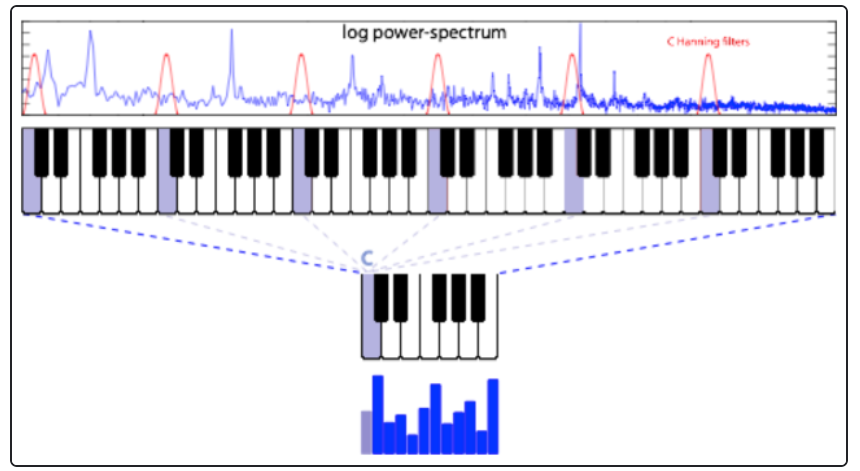;
- `audio_avg_timbre`: Timbre is the quality of a musical note or sound that distinguishes different types of musical instruments, or voices. It is a complex notion also referred to as sound color, texture, or tone quality, and is derived from the shape of a segment’s spectro-temporal surface, independently of pitch and loudness. The timbre feature is a vector that includes 12 unbounded values roughly centered around 0. Those values are high level abstractions of the spectral surface, ordered by degree of importance.
For completeness however, the first dimension represents the average loudness of the segment; second emphasizes brightness; third is more closely correlated to the flatness of a sound; fourth to sounds with a stronger attack; etc. See an image below representing the 12 basis functions (i.e. template segments).
The actual timbre of the segment is best described as a linear combination of these 12 basis functions weighted by the coefficient values: timbre = c1 x b1 + c2 x b2 + ... + c12 x b12, where c1 to c12 represent the 12 coefficients and b1 to b12 the 12 basis functions as displayed below. Timbre vectors are best used in comparison with each other (_categorical_);
  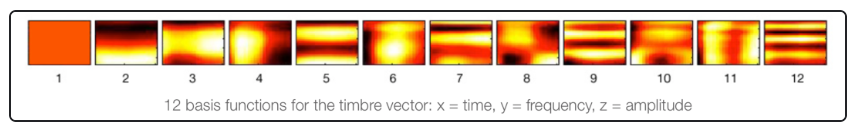
- `audio_acousticness`: A confidence measure from `0.0` to `1.0` of whether the track is acoustic. `1.0` represents high confidence the track is acoustic.
(_numerical_, _continuos_);
- `audio_danceability`:Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of `0.0` is least danceable and `1.0` is most danceable. (_numerical_, _continuos_);
- `audio_duration_ms`: The duration of the track in milliseconds (_numerical_, _discrete_);
- `audio_energy`: Energy is a measure from `0.0` to `1.0` and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. (_numerical_, _continuos_);
- `audio_instrumentalness`: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to `1.0`, the greater likelihood the track contains no vocal content. Values above `0.5` are intended to represent instrumental tracks, but confidence is higher as the value approaches `1.0`.
- `audio_key_1` : The key the track is in. Integers map to pitches using standard [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.(>= -1, <= 11).
- `audio_liveness`: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above `0.8` provides strong likelihood that the track is live.
- `audio_loudness`: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
- `audio_mode_1`: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- `audio_speechiness`: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- `audio_tempo`: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- `audio_time_signature`:  An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4" (>= 3, <= 7).
- `audio_valence`: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [15]:
spotify_tracks.show(5)

+--------------------+-----------------+--------------+----------------+--------------------+------------------+----------------------------+---------------+--------------------+--------------------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+--------------------+-----------+
|                  id|       track_name|track_explicit|track_popularity|          album_name|album_release_date|album_release_date_precision|    artist_name|   audio_avg_pitches|    audio_avg_timbre|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|           track_uri|track_genre|
+--------------------+-----------------+--------------+----------------+--------------------+-----------------

In [16]:
# Drop duplicates and split the columns using PySpark
print("Before Drop-Duplicates: ", spotify_tracks.count())
spotify_tracks = spotify_tracks.dropDuplicates()
print("After Drop-Duplicates: ", spotify_tracks.count())

Before Drop-Duplicates:  79339
After Drop-Duplicates:  64950


## **Dataset Manipulation**

In [17]:
# We build a Function to split the array columns of the database more time, 
# one for the original dataset and one for the playlist dataset

def split_array_columns(data, col_name, new_col_name):
  """
    Input:
     - data: it is the dataset,
     - col_name: name of the column that we will split
     - new_col_name: name of the new columns
  """
  temp_name = col_name+'_list'

  # Delete the '[]'
  data = data.select(data.columns + [translate(col(col_name), "[]", "").alias(temp_name)])

  ### Split the string into new columns and cast it to double

  # Defining Split Function
  split_col = split(data[temp_name], ', ')
  
  for i in range(12):
    data = data.withColumn(new_col_name+str(i), split_col.getItem(i))
    i_name = new_col_name+str(i)
    # Cast converted columns
    data = data.withColumn(i_name, data[i_name].cast("double"))
  
  # Drop unless columns
  cols_to_drop = (col_name, col_name+"_list")
  data = data.drop(*cols_to_drop)

  return data

In [18]:
# Function to convert string to datetime
def to_date_(col, formats=("yyyy-MM-dd", "y")):
    """
      Input:
      - col: name of the column that we will split
      - formats: all possible format for the date string
    """
    # Spark 2.2 or later syntax, for < 2.2 use unix_timestamp and cast
    return coalesce(*[to_date(col, f) for f in formats])

# Function to split and cast (to int) date in 3 columns: year, month, day
def split_date(data, col_name):
  """
    Input:
     - data: it is the dataset,
     - col_name: name of the column that we will split
  """
  # Convert to date format
  data = data.withColumn(col_name+"_td", to_date_(col_name))

  # Split date to columns
  temp_name = col_name+'_td'
  data = data.withColumn('day', dayofmonth(data[temp_name]))
  data = data.withColumn('month', month(data[temp_name]))
  data = data.withColumn('year', year(data[temp_name]))

  # cast to int type
  data = data.withColumn("year", data.year.cast('int'))\
              .withColumn("day", data.day.cast('int'))\
              .withColumn("month", data.month.cast('int'))

  # Drop unless columns
  cols_to_drop = (col_name, col_name+"_td")
  data = data.drop(*cols_to_drop)

  return data

In [19]:
# Split Array Columns
spotify_tracks_splitted = split_array_columns(spotify_tracks, "audio_avg_pitches", "pitch_")
spotify_tracks_splitted = split_array_columns(spotify_tracks_splitted, "audio_avg_timbre", "timbre_")
del spotify_tracks

# Split Date Columns
spotify_tracks = split_date(spotify_tracks_splitted, "album_release_date")
del spotify_tracks_splitted

In [20]:
spotify_tracks.printSchema()

root
 |-- id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio_time_signature: integer (nullable = true)
 |-- audio_valence: double (nullable = true)
 |-- track_uri: string (nullable = true)
 |-- track_genre: 

## Delete possible `null` Value

In [21]:
# null values in each column
spotify_tracks.agg(*[count(when(isnull(c), c)).alias(c) for c in spotify_tracks.columns]).show()

+---+----------+--------------+----------------+----------+----------------------------+-----------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+---------+-----------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---+-----+----+
| id|track_name|track_explicit|track_popularity|album_name|album_release_date_precision|artist_name|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|track_uri|track_genre|pitch_0|pitch_1|pitch_2|pitch_3|pitch_4|pitch_5|pitch_6|pitch_7|pitch_8|pitch_9|pitch_10|pitch_11|timbre_0|t

In [22]:
print("Before: ", spotify_tracks.count())
spotify_tracks = spotify_tracks.dropna()
print("After: ", spotify_tracks.count())

Before:  64950
After:  64950


# **Data Exploration**

In this section of the notebook, we're going to explore our dataframe and we show some graphics, i.e. the correlation map of the feaure, the most famous tracks, the most famous artists and so on.

In [23]:
# To access plotting libraries, we need to first transform our PySpark DataFrame 
# into a Pandas DataFrame
spotify_tracks_pd = spotify_tracks.toPandas() 

## Function that reverses the dictionary, then used to discretize musical genres

Spotify supports a total of 126 genres. To facilitate the classification problem and discretize the genres, we manually created a json file in which we group the similar genres, obtaining 12 Big-Genres. To do this, we researched the historical / social influences of the various genres to see each one from which other genre it originates and to which it can be approached.

In the following function we invert the keys of the json in order to then carry out the mapping of the genres and therefore the discretization.

In [24]:
# Reverse the keys of the json to map the genres 
def invert_dict(): 
    # Get Json File 
    f = open(GDRIVE_JSON_GENRE_FILE)
    d = json.load(f)
    f.close()

    inverse = dict() 
    for key in d: 
        # Foreach Sub-genres of the Big-genres
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = key 
    return inverse

# variable to store json later
map_genre_inv = {}

## Visualization of Variability for some columns in the dataframe

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

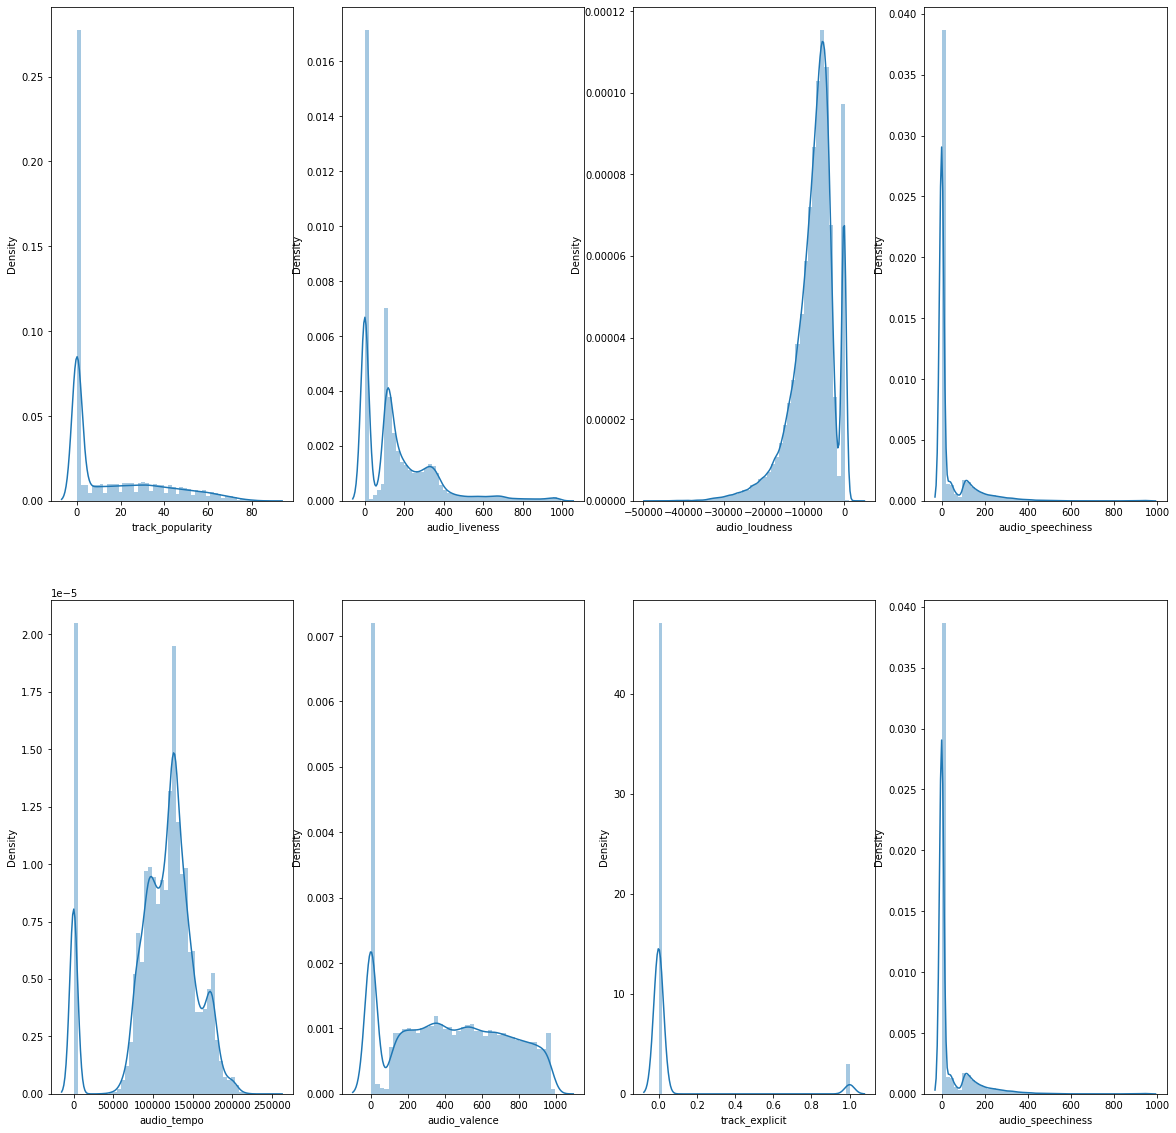

In [25]:
#Visualisation of Variability for some columns in the dataframe
fig,ax = plt.subplots(2,4,figsize=(20,20))

sns.distplot(spotify_tracks_pd['track_popularity'],ax=ax[0,0])
sns.distplot(spotify_tracks_pd['audio_liveness'],ax=ax[0,1])
sns.distplot(spotify_tracks_pd['audio_loudness'],ax=ax[0,2])
sns.distplot(spotify_tracks_pd['audio_speechiness'],ax=ax[0,3])
sns.distplot(spotify_tracks_pd['audio_tempo'],ax=ax[1,0])
sns.distplot(spotify_tracks_pd['audio_valence'],ax=ax[1,1])
sns.distplot(spotify_tracks_pd['track_explicit'],ax=ax[1,2])
sns.distplot(spotify_tracks_pd['audio_speechiness'],ax=ax[1,3])

## Correlation Map

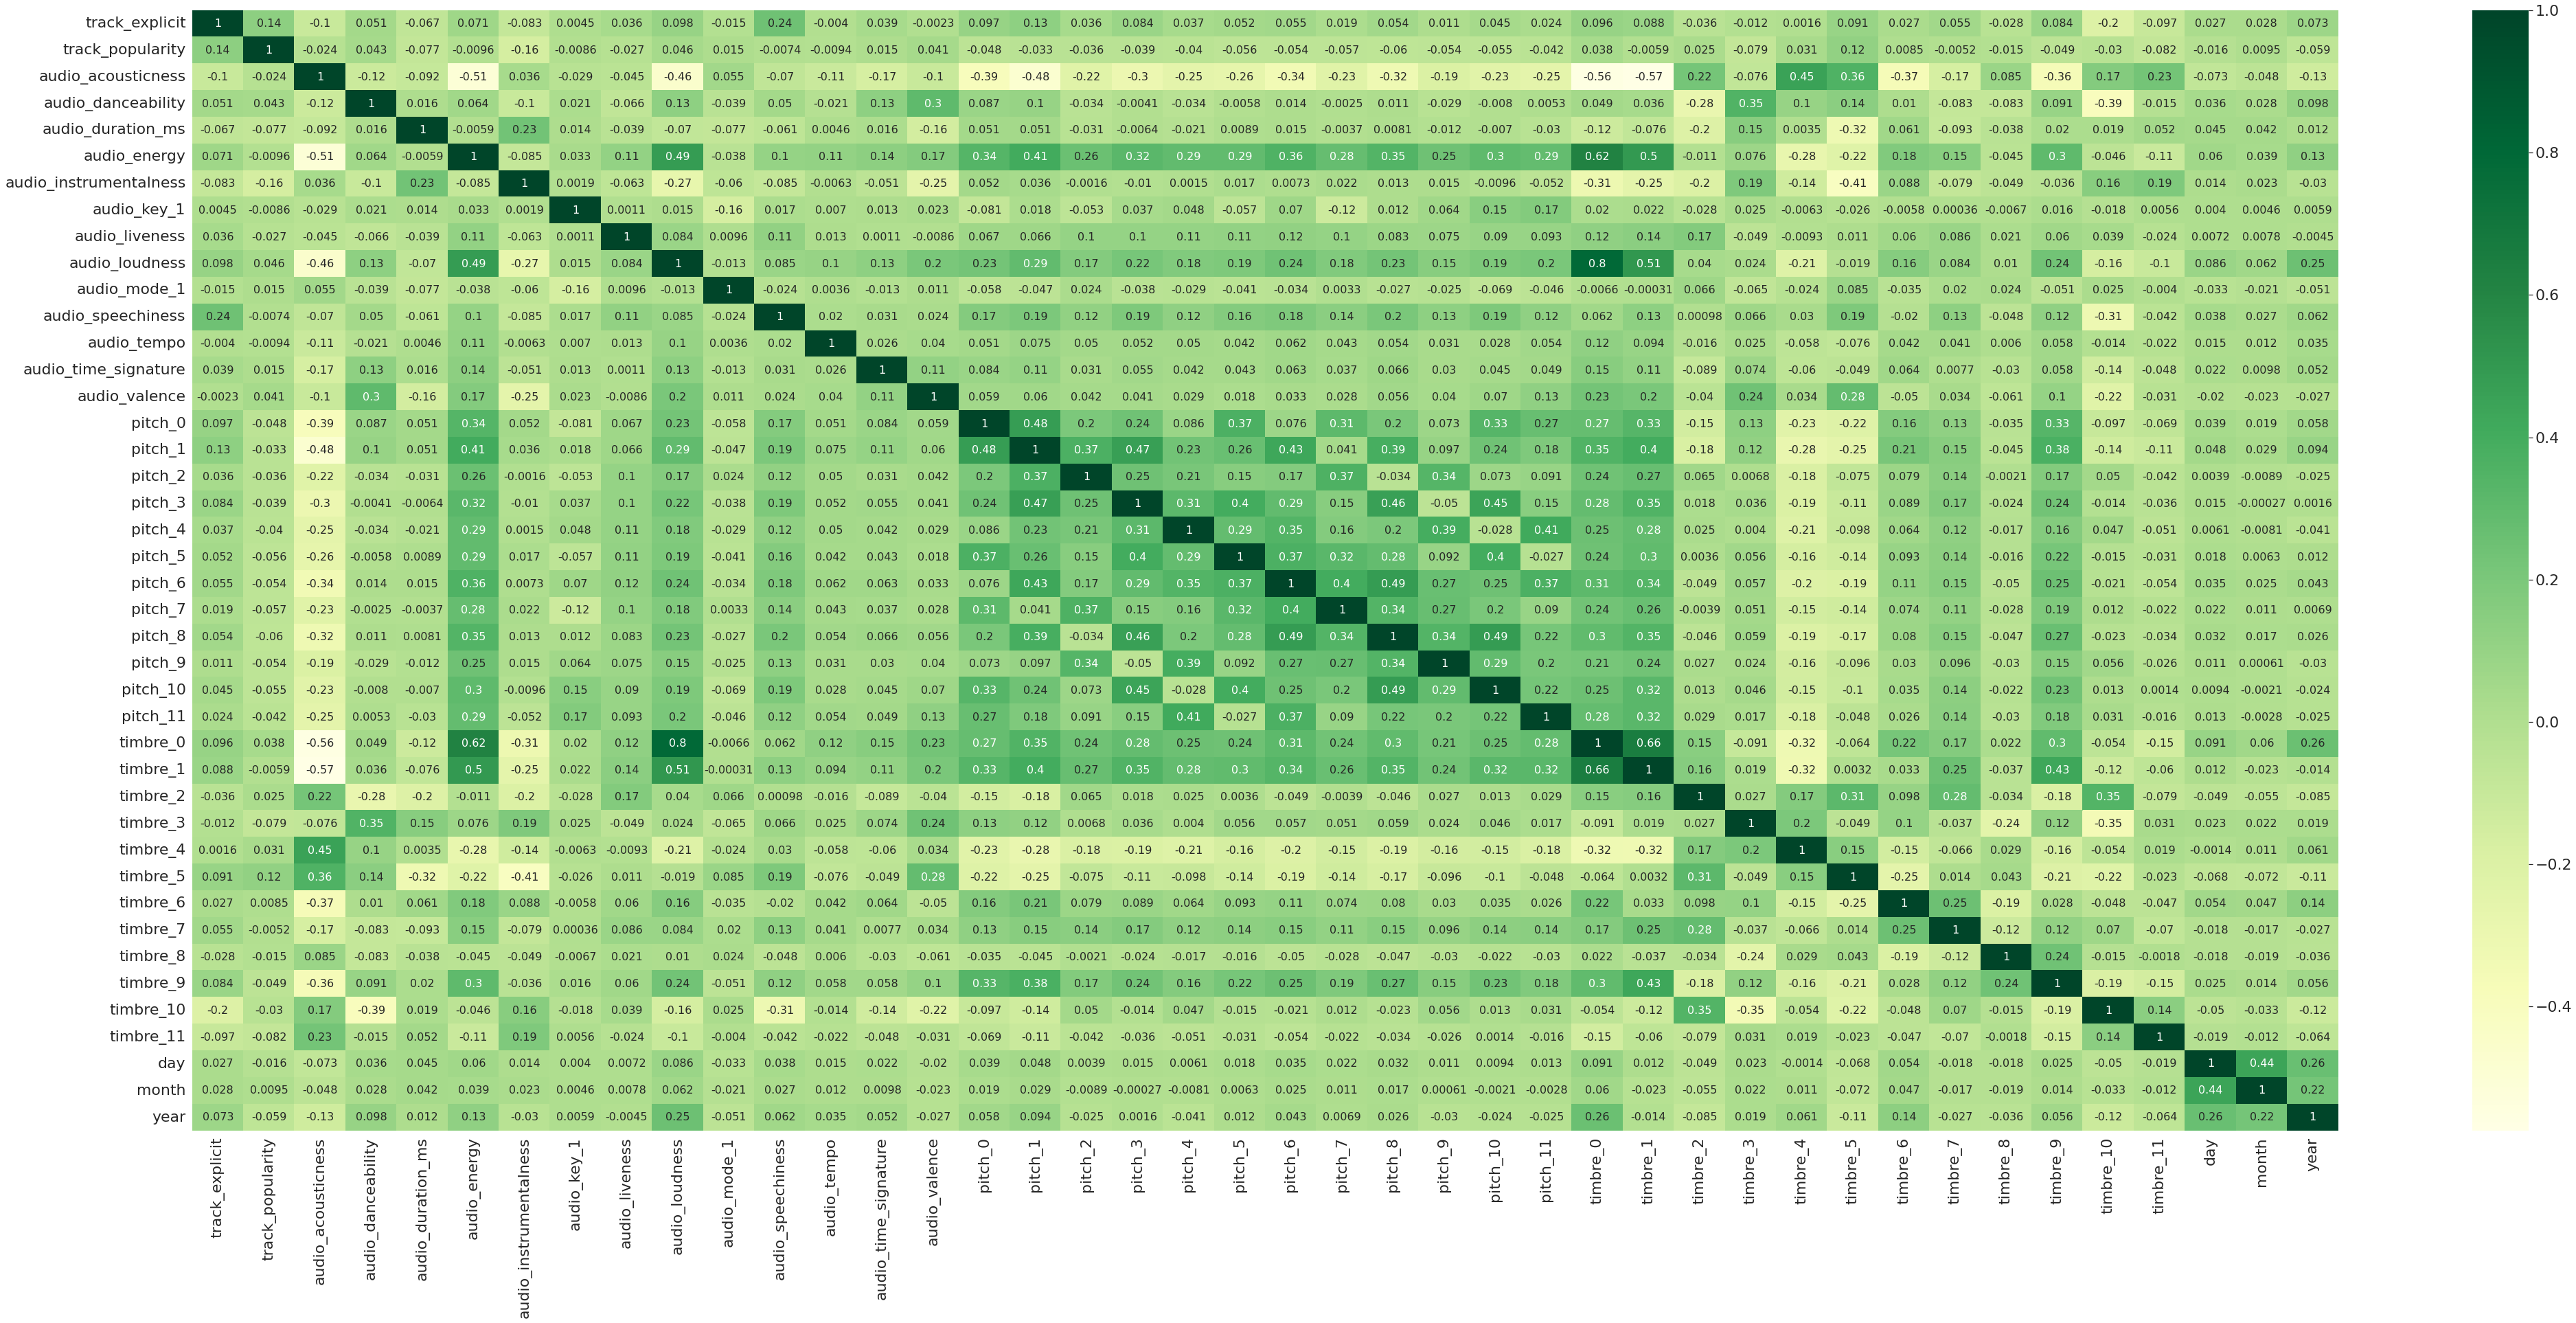

In [26]:
plt.figure(figsize=(70,30))
sns.set(font_scale=2) # font size 2
corr = spotify_tracks_pd.corr()
sns.heatmap(corr,annot=True,cmap='YlGn',annot_kws={"fontsize":16}) # BrBG_r
sns.set(font_scale=1)

As we can see from the correlation map that there are no highly correlated features so for now it is not necessary to drop any columns.

## Most Popular Tracks

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0.,  20.,  40.,  60.,  80., 100.]),
 <a list of 6 Text major ticklabel objects>)

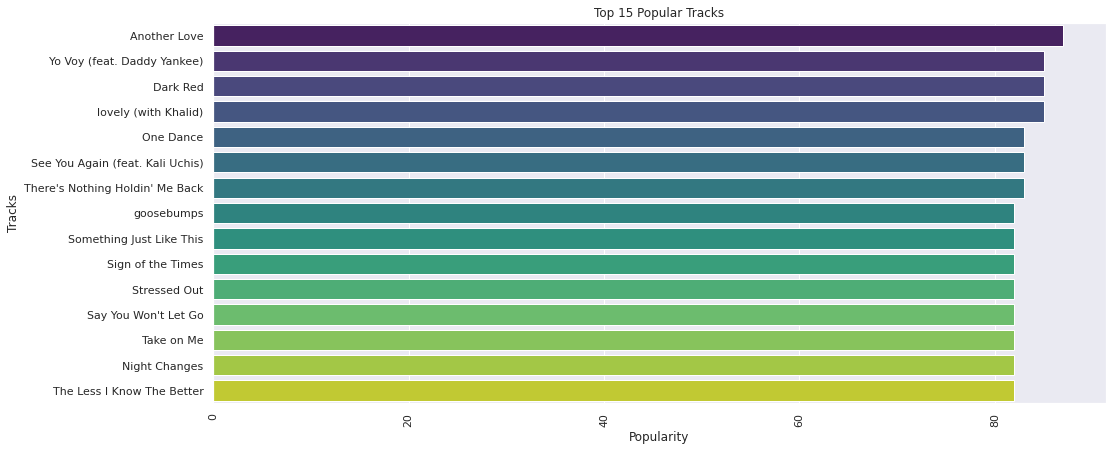

In [27]:
#Most Popular Tracks
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd.groupby("track_name")['track_popularity'].mean().sort_values(ascending=False).head(15)
axis = sns.barplot(popular,popular.index,palette="viridis",orient = 'h')
axis.set_title('Top 15 Popular Tracks')
axis.set_ylabel('Tracks')
axis.set_xlabel('Popularity')
plt.xticks(rotation = 90)

## Most Popular Artists

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([   0., 1000., 2000., 3000., 4000., 5000.]),
 <a list of 6 Text major ticklabel objects>)

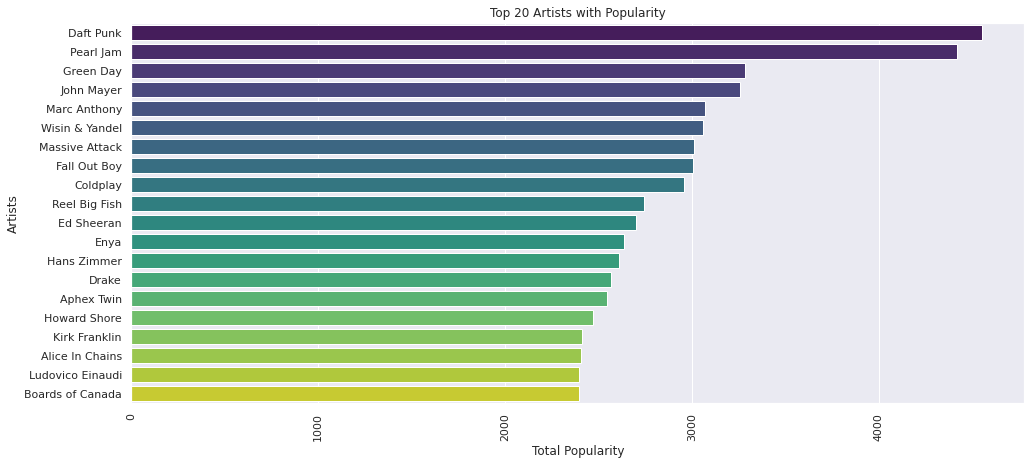

In [28]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd.groupby("artist_name")['track_popularity'].sum().sort_values(ascending=False)[:20]
axis = sns.barplot(popular,popular.index,palette="viridis",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Artists')
axis.set_xlabel('Total Popularity')
plt.xticks(rotation = 90)

## Most present Artist

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 9 Text major ticklabel objects>)

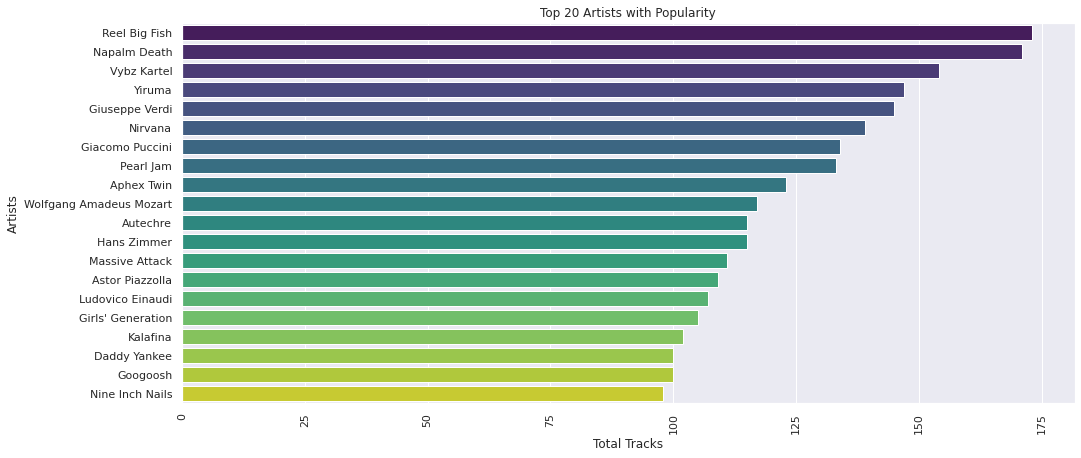

In [29]:
#Most Popular Artists
fig, axis = plt.subplots(figsize = (16,7))
popular = spotify_tracks_pd["artist_name"].value_counts()[:20]
#popular.columns = ['feature','nunique']
#axis = sns.barplot(x='feature', y='nunique', data=popular, palette="mako")
axis = sns.barplot(popular, popular.index, palette="viridis",orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Artists')
axis.set_xlabel('Total Tracks')
plt.xticks(rotation = 90)

## Number of songs released Year Wise

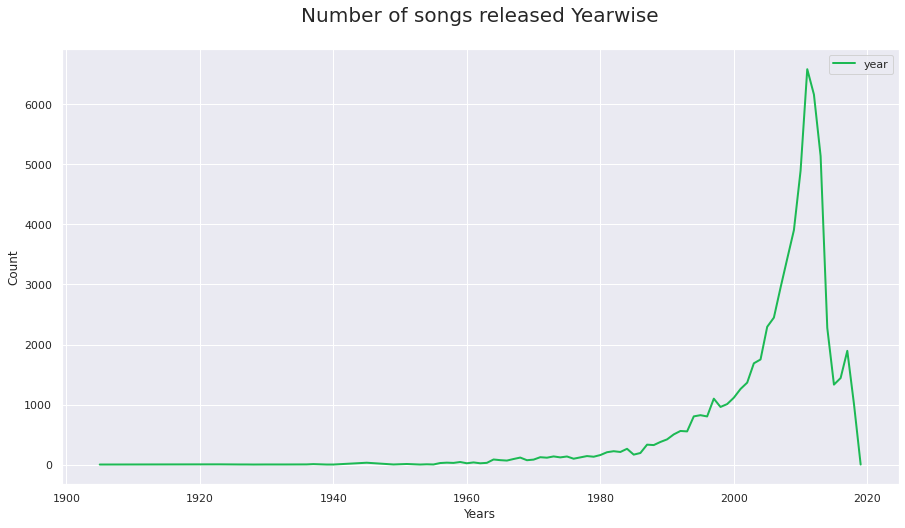

In [30]:
year = pd.DataFrame(spotify_tracks_pd['year'].value_counts())
year = year.sort_index()
ax=year.plot(kind='line',figsize=(15,8) ,color='#1db954', linewidth=2)
plt.title("Number of songs released Yearwise",y=1.05,fontsize=20)
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

## Year VS Popularity

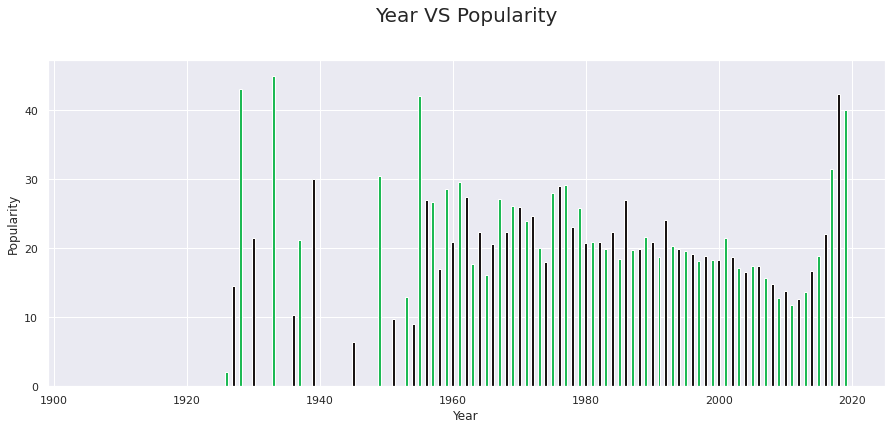

In [31]:
keypop = pd.DataFrame(spotify_tracks_pd.groupby('year')['track_popularity'].mean()).reset_index()

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['year'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#1db954','#191414'])
plt.title('Year VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Year')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

Apart from a few exceptions due to the small dataset, the popularity increases over the years. This is also due to the increase in people using Spotify.

## Danceability VS Popularity

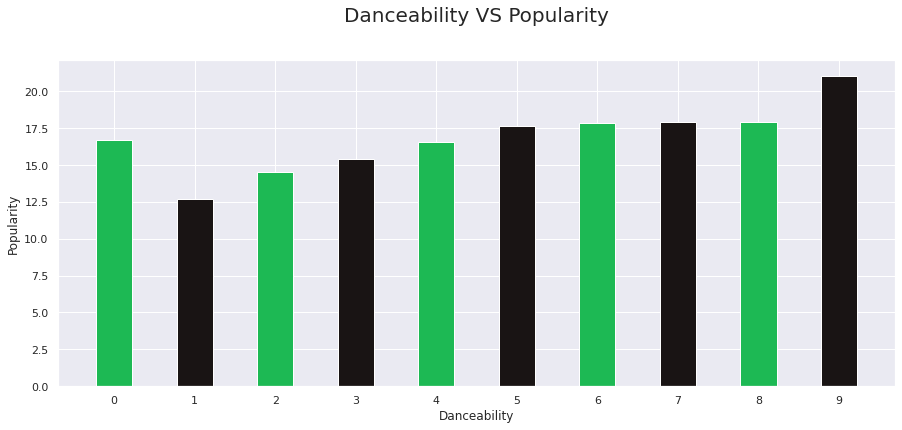

In [32]:
bins = [i for i in range(0, 1001, 100)]
names = [str(i) for i in range(10)]

spotify_tracks_pd['audio_danceability_map'] = pd.cut(spotify_tracks_pd['audio_danceability'], bins, labels=names)

keypop = pd.DataFrame(spotify_tracks_pd.groupby('audio_danceability_map')['track_popularity'].mean()).reset_index()

fig = plt.figure(figsize=(15,6))
plt.bar( keypop['audio_danceability_map'],
         keypop['track_popularity'],
         width=0.45,
         color = ['#1db954','#191414'])
plt.title('Danceability VS Popularity',y=1.1,fontsize=20)
plt.xlabel('Danceability')
plt.ylabel('Popularity')
ax.axes.get_xaxis().set_visible(True)

We can see that as danceability increases, so does popularity except for the 0 value, perhaps because Spotify sets it as the default if it doesn't have enough information.

## Key VS Genre

This chart shows the most popular keys for each genre.

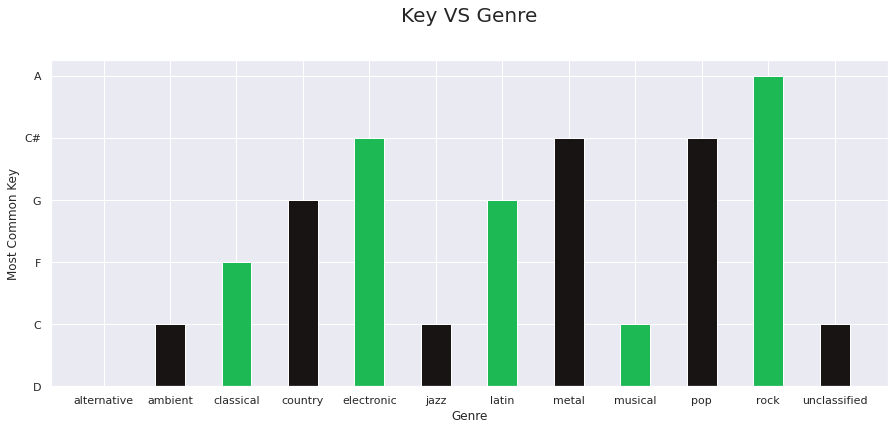

In [33]:
map_genre_inv = invert_dict()

key_genre = pd.DataFrame(spotify_tracks_pd)
key_genre["track_genre"].replace(map_genre_inv, inplace=True)
key_genre.replace({'audio_key_1' : { 0 : 'C', 1 : 'C#', 2 : 'D', 3 : 'D#', 4 : 'E', 5 : 'F', 6 : 'F#', 
                        7 : 'G', 8 : 'G#', 9 : 'A', 10 : 'A#', 11 : 'B'}} , inplace=True)

# Aggregate most common key by genre
key_genre = key_genre.groupby(['track_genre'])['audio_key_1'].agg(pd.Series.mode)

# set column name
key_genre = pd.DataFrame({"track_genre":key_genre.index, "audio_key_1":key_genre.values})

# Some genre have more than one key
key_list = []
for key in key_genre["audio_key_1"].values:
  if type(key) == str:
    key_list.append(key)
    
  else:
    key_list.append(key[0])

fig = plt.figure(figsize=(15,6))
plt.bar( key_genre["track_genre"],
         key_list,
         width=0.45,
         color = ['#1db954','#191414'])
plt.title('Key VS Genre',y=1.1,fontsize=20)
plt.xlabel('Genre')
plt.ylabel('Most Common Key')
ax.axes.get_xaxis().set_visible(True)


In [34]:
del spotify_tracks_pd

# **Preprocessing**

The preprocessing phase is fundamental in Machine Learning, in fact, the data is rarely ready for use, it can contain typos, it can have missing values and also the data may not be normalized. We therefore need to do some preprocessing work to "clean" and normalize the data.

## Discretize

### Discretize the Music Genres

In [35]:
# Get the inverted dict if not exists
if map_genre_inv == {}:
  map_genre_inv = invert_dict()

In [36]:
# Map the 126 genres to 12 Big-Genres from the dict file
udf_foo = udf(lambda x: map_genre_inv[x], StringType())
spotify_tracks = spotify_tracks.withColumn("track_genre", udf_foo("track_genre"))

In [37]:
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,unclassified,rock,classical,latin
count,5995,6000,2722,13579,2896,5315,3189,3600,8950,5283,2393,5028


In [38]:
spotify_tracks = spotify_tracks.filter(spotify_tracks.track_genre != 'unclassified')
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,rock,classical,latin
count,5995,6000,2722,13579,2896,5315,3189,3600,5283,2393,5028


We drop the "unclassified" rows because contains all Spotify genres that are not properly real genres, for example we esclude Nation genre (like british, french ecc).

In [39]:
# Do some cleaning
try:
  del ax, axis, bins, corr, fig, key, key_genre, key_list, keypop, map_genre_inv, names, popular, year
except:
  print("Some variables are not declared")

In [40]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string, pitch_0: double, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, timbre_0: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, day: int, month: int, year: int]

In [41]:
# First save a copy for the recommandation system and 
# delete the variable to save memory
all_tracks = spotify_tracks.toPandas()
all_tracks.drop('track_uri', axis=1, inplace=True)
all_tracks.to_csv("full_pandas_all_tracks.csv")

del all_tracks

In [42]:
print("Garbage collector: collected %d objects" % (gc.collect()))

Garbage collector: collected 50 objects


In [43]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string, pitch_0: double, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, timbre_0: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, day: int, month: int, year: int]

## Balancing the Dataset

We decided to apply random sample to undersampling the datasets for two reasons:
- get around memory-related problems while running  (during cross validation).
- many algorithms suffer if the classes are not balanced, if we have two classes, call it class A and class B if class A represents 90% of the dataset an algorithm can completely ignore the minority class (class B). 

To remedy the problems we tried to run the project both locally and on other platforms such as Kaggle or Paperspace DataFrame, without however solving the problem.

With the complete dataset we always get the following error:
- `Py4JError: An error occurred while calling oXX.fit`

Searching the internet we found that it is caused by the JVM crash, in most cases due to memory problems. We also have confirmation from the console log which returns the following warning:

- `WARN DAGScheduler: Broadcasting large task binary with size 1544.2 KiB`


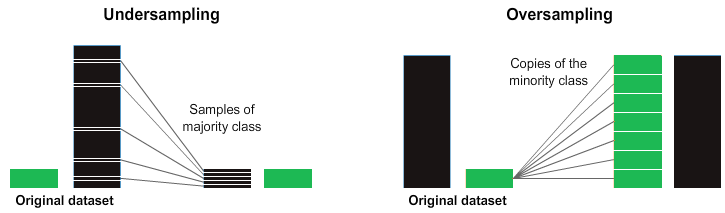

In [44]:
# Balance and create dataset for genre prevision
fractions_dict = spotify_tracks.groupBy('track_genre').count().toPandas().to_dict()

fraction = {}
for genre in fractions_dict["track_genre"]:
  g = fractions_dict["track_genre"][genre]
  # Apply UnderSampling
  fraction[g] = 1200 / fractions_dict["count"][genre] 
  # We choose this value (1200) because with 13200 rows we don't fille the RAM 
  # of colab during Cross validation

del fractions_dict

spotify_tracks = spotify_tracks.sampleBy("track_genre", fractions=fraction, seed=0)
spotify_tracks.groupBy('track_genre').count().toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10
track_genre,pop,alternative,ambient,electronic,jazz,country,musical,metal,rock,classical,latin
count,1241,1200,1193,1227,1228,1179,1212,1216,1214,1181,1198


In [45]:
spotify_tracks.cache()

DataFrame[id: string, track_name: string, track_explicit: boolean, track_popularity: int, album_name: string, album_release_date_precision: string, artist_name: string, audio_acousticness: double, audio_danceability: double, audio_duration_ms: int, audio_energy: double, audio_instrumentalness: double, audio_key_1: int, audio_liveness: double, audio_loudness: double, audio_mode_1: int, audio_speechiness: double, audio_tempo: double, audio_time_signature: int, audio_valence: double, track_uri: string, track_genre: string, pitch_0: double, pitch_1: double, pitch_2: double, pitch_3: double, pitch_4: double, pitch_5: double, pitch_6: double, pitch_7: double, pitch_8: double, pitch_9: double, pitch_10: double, pitch_11: double, timbre_0: double, timbre_1: double, timbre_2: double, timbre_3: double, timbre_4: double, timbre_5: double, timbre_6: double, timbre_7: double, timbre_8: double, timbre_9: double, timbre_10: double, timbre_11: double, day: int, month: int, year: int]

## Delete unless columns

In [46]:
# Delete columns
cols = ("track_uri", "id")
spotify_tracks = spotify_tracks.drop(*cols)
# spotify_tracks_popularity = spotify_tracks_popularity.drop(*cols)

## Get Categorical and Numerical Features

In [47]:
# Function to get categorical and numerical features
def get_features_type(ds, target):
  categorical, numerical = [], []

  #Get All column names and it's types
  for col in ds.dtypes:
      if col[1] == "string":
          categorical.append(col[0])
      else:
          numerical.append(col[0])

  if target != "":
    if target in categorical:
      categorical.remove(target)
    if target in numerical:
      numerical.remove(target)
      
  print("Categorical Popularity Dataset: ", categorical)
  print("Numerical Popularity Dataset: ", numerical)

  return categorical, numerical

In [48]:
TARGET_VARIABLE_POPULARITY = "track_popularity"
CATEGORICAL_FEATURES_POPULARITY, NUMERICAL_FEATURES_POPULARITY = get_features_type(spotify_tracks, TARGET_VARIABLE_POPULARITY)

Categorical Popularity Dataset:  ['track_name', 'album_name', 'album_release_date_precision', 'artist_name', 'track_genre']
Numerical Popularity Dataset:  ['track_explicit', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'day', 'month', 'year']


In [49]:
TARGET_VARIABLE_GENRE = "track_genre"
CATEGORICAL_FEATURES_GENRE, NUMERICAL_FEATURES_GENRE = get_features_type(spotify_tracks, TARGET_VARIABLE_GENRE)

Categorical Popularity Dataset:  ['track_name', 'album_name', 'album_release_date_precision', 'artist_name']
Numerical Popularity Dataset:  ['track_explicit', 'track_popularity', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'day', 'month', 'year']


## Transform Categorical features into Numerical

Note that this step is not always mandatory (e.g., decision trees are able to work nicely with categorical features without the need of transforming them to numerical). Still, other methods (like logistic regression) are designed to operate with numerical inputs only.

To transform _categorical_ features into _numerical_ ones we proceed as follows.
We setup a pipeline which is composed of the following steps:
- [`StringIndexer`](https://spark.apache.org/docs/latest/ml-features#stringindexer): encodes a string column of labels to a column of label indices. The indices are in `[0, numLabels)`, and 4 ordering options are supported (default `frequencyDesc`, which assigns the most frequent label the index `0`, and so on and so forth).
- [`VectorAssembler`](https://spark.apache.org/docs/latest/ml-features#vectorassembler): is a transformer that combines a given list of columns into a single vector column.
- [`StandardScaler`](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html): transforms a dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean:
$$
  z = \frac{x-\mu}{\sigma}
$$
where $\mu$ is the sample mean of the feature, and $\sigma$ is the unbiased sample standard deviation (computed from all the observations).
In such a way, each $z$ will have $0$-mean and $1$-standard-deviation.

In [50]:
# This function is responsible to implement the pipeline above for transforming categorical features into numerical ones
def to_numerical(df, numerical_features, categorical_features, target_variable=None):
  
    # 1. Label Encode target feature
    # In this case our target is the popularity of the tracks that is just
    # numeric in our dataframe, so there is no need to encode it 
    if target_variable != None:
      label_indexer = StringIndexer(inputCol=target_variable, outputCol='label')

    # 2. Label Encode Categorical features
    indexer = [StringIndexer(inputCol=c, outputCol="{0}_index".format(c), handleInvalid="skip") for c in categorical_features]

    # 3. create a vector of all the features required to train the logistic regression model 
    assembler = VectorAssembler(inputCols= [i.getOutputCol() for i in indexer] + numerical_features, outputCol='features')

    # 3.a Create the StandardScaler
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol="std_" + assembler.getOutputCol(), withStd=True, withMean=True)


    # 5. Populate the stages of the pipeline
    ## for the recommandation step the target variable is empty
    if target_variable != None:
      stages = [label_indexer] + indexer + [assembler] + [scaler] 
    else:
      stages = indexer + [assembler] + [scaler]

    # 6. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=stages)

    # 7. Transform the input dataframe accordingly
    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)

    return df_transformed

## **Split the Dataset into train and test set**
### **Dataset Splitting: Training vs. Test Set**

Before moving along with any preprocessing involving data transformations, we will split our dataset into **2** portions:
- _training set_ (e.g., accounting for **80%** of the total number of instances);
- _test set_ (e.g., accounting for the remaining **20%** of instances)

In [51]:
# GENRE DATASET

# Transform the training set and get back both the transformer and the new dataset
spotify_tracks_genre = to_numerical(spotify_tracks, NUMERICAL_FEATURES_GENRE, CATEGORICAL_FEATURES_GENRE, TARGET_VARIABLE_GENRE)

spotify_tracks_genre = spotify_tracks_genre.select(["std_features", "label"])


RANDOM_SEED = 42
# Randomly split our original dataset into 80÷20 for training and test, respectively
train_set_genre, test_set_genre = spotify_tracks_genre.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_set_genre.show()

+--------------------+-----+
|        std_features|label|
+--------------------+-----+
|[-1.5888263299358...|  6.0|
|[-1.5404119440614...| 10.0|
|[-1.4906819498751...|  5.0|
|[-1.4717371901851...|  5.0|
|[-1.4335845491428...|  9.0|
|[-1.3896432315285...|  9.0|
|[-1.1928282280825...|  5.0|
|[-1.1383620439738...|  8.0|
|[-0.9565449752824...|  2.0|
|[-0.9173398475906...|  3.0|
|[-0.8476126070649...|  9.0|
|[-0.7894627196832...|  1.0|
|[-0.7876208680466...| 10.0|
|[-0.7339440489250...| 10.0|
|[-0.7310497106390...|  7.0|
|[-0.7102630993125...|  5.0|
|[-0.6363259121891...|  8.0|
|[-0.6034357043940...|  7.0|
|[-0.1900715728249...| 10.0|
|[-0.1053463975446...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [52]:
train_set_genre.cache()

DataFrame[std_features: vector, label: double]

In [53]:
# POPULARITY DATASET

spotify_tracks = spotify_tracks.withColumnRenamed(TARGET_VARIABLE_POPULARITY,"label")
# Transform the training set and get back both the transformer and the new dataset
spotify_tracks_popularity = to_numerical(spotify_tracks, NUMERICAL_FEATURES_POPULARITY, CATEGORICAL_FEATURES_POPULARITY)

spotify_tracks_popularity = spotify_tracks_popularity.select(["std_features", "label"])

RANDOM_SEED = 42
# Randomly split our original dataset into 80÷20 for training and test, respectively
train_set_popularity, test_set_popularity = spotify_tracks_popularity.randomSplit([0.8, 0.2], seed=RANDOM_SEED)

train_set_popularity.show()

+--------------------+-----+
|        std_features|label|
+--------------------+-----+
|[-1.5888263299358...|   36|
|[-1.5404119440614...|   78|
|[-1.4906819498751...|   25|
|[-1.4717371901851...|    0|
|[-1.4335845491428...|    0|
|[-1.3896432315285...|   20|
|[-1.1928282280825...|   33|
|[-1.1383620439738...|   22|
|[-0.9565449752824...|    0|
|[-0.9173398475906...|    0|
|[-0.8476126070649...|   35|
|[-0.7894627196832...|    0|
|[-0.7876208680466...|   54|
|[-0.7339440489250...|    0|
|[-0.7310497106390...|    0|
|[-0.7102630993125...|    0|
|[-0.6363259121891...|   41|
|[-0.6034357043940...|   23|
|[-0.1900715728249...|    0|
|[-0.1053463975446...|   70|
+--------------------+-----+
only showing top 20 rows



In [54]:
train_set_popularity.cache()

DataFrame[std_features: vector, label: int]

# Training

In this section we will perform the training of the models, the classifiers used to predict the musical genre are the following:
- **Decision Tree Classifier**
- **Logistic Regression**
- **Random Forest**
- **MLPNs (Multi-layer Perceptrons Network)**
- **K-means clustering**

While the regressors used to predict the popularity of a piece of music are the following:
- **Decision Tree Regressor**
- **Linear Regression**

## Classifier

### Decision Tree

Decision Tree is a supervised machine learning algorithm that creates a tree with three important components:
- Test node: that is a test on a specific feature;
- Leaf node: that represents a decision (classification);
- Edge: that can link two test nodes or one test node to a leaf node.
A decision tree can be re-written as a set of rules and the "function" to minimize is the depth of the tree, but is a NP-Hard problem and so a Greedy technique is even good. One possibility is to define "the order" of testing the different features, based for example on the information gain that is based on the entropy that represents the "disorder" of the set (of instances) that we are using.

An example of Decision tree is provided in the figure below

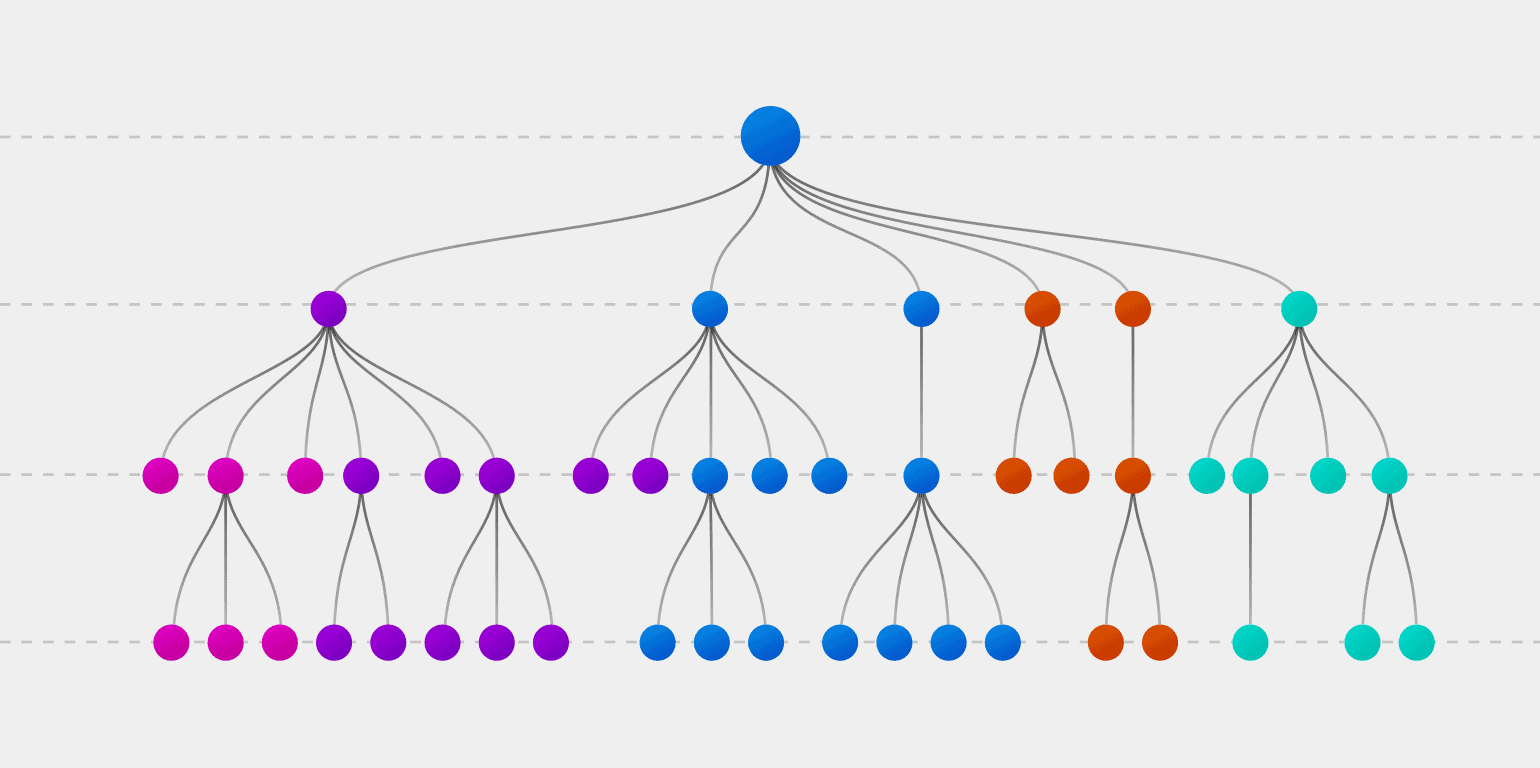

In [ ]:
# This function defines the general pipeline for decision tree
def decision_tree_pipeline(train):
  
  decision_tree = DecisionTreeClassifier(featuresCol='std_features',labelCol='label')

  #### DECISION TREE
  param_grid = ParamGridBuilder()\
    .addGrid(decision_tree.maxDepth, [3, 5, 7]) \
    .addGrid(decision_tree.impurity, ["gini", "entropy"]) \
    .build()
  cross_val_dt = CrossValidator(estimator = decision_tree,
                                estimatorParamMaps = param_grid,
                                evaluator = MulticlassClassificationEvaluator(),
                                numFolds = 5,
                                collectSubModels = False,
                                parallelism = 2
                                )
  
  cv_model_dt = cross_val_dt.fit(train)

  return cv_model_dt

In [ ]:
start_time = time.time()
cv_model_genre_dt = decision_tree_pipeline(train_set_genre)
end_time = time.time()

print("Time Required: %s seconds" % (end_time - start_time))

In [ ]:
cv_model_genre_dt.write().overwrite().save(PATH_DT_GENRE)

In [ ]:
test_predictions_genre_dt = cv_model_genre_dt.transform(test_set_genre)

test_predictions_genre_dt.select("std_features", "prediction", "label").show(5)

### **Logistic Regression**



We first train a logistic regression model, using the training set above. To do so, we use the `LogisticRegression` object provided by the [PySpark API](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression) within the package `pyspark.ml.classification`.

The API is similar to the one we have seen for Linear Regression (i.e., implementing the **Elastic Net** regularization framework), except for the loss function which now is **cross-entropy** rather than **mean squared error**:
$$
\boldsymbol{\theta}^* = \text{argmin}_{\boldsymbol{\theta}\in \mathbb{R}^n} \frac{1}{m} \sum_{i=1}^m \log_e(1 + e^{-y_i\boldsymbol{\theta}^T\mathbf{x}_i}) + \lambda\Big(\alpha |\boldsymbol{\theta}| + (1-\alpha)||\boldsymbol{\theta}||^2\Big)
$$
In particular, we can specify the following parameters:

- `regParam` is the regularization parameter (or $\lambda$);
- `elasticNetParam` is the tradeoff parameter for regularization penalties (or $\alpha$);
  - `regParam = 0` and `elasticNetParam = 0` means there is no regularization;
  - `regParam > 0` and `elasticNetParam = 0` means there is only L2-regularization; 
  - `regParam > 0` and `elasticNetParam = 1` means there is only L1-regularization;
  - `regParam > 0` and `0 < elasticNetParam < 1` means there is both L1- and L2-regularization (Elastic Net);

As it is always the case, the optimal values of those **hyperparameters** should be tuned using a dedicated portion of the dataset (i.e., **validation set**) or by performing $k$**-fold cross validation**.

In [ ]:
# This function defines the general pipeline for logistic regression
def logistic_regression_pipeline(train):
  
    logistic_regression = LogisticRegression(featuresCol='std_features',labelCol='label')

    #### LOGISTIC REGRESSION
    param_grid = ParamGridBuilder()\
    .addGrid(logistic_regression.regParam, [0.0, 0.1, 1.0]) \
    .addGrid(logistic_regression.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(logistic_regression.maxIter, [10, 20]) \
    .build()

    cross_val_lg = CrossValidator(estimator = logistic_regression, 
                            estimatorParamMaps = param_grid,
                            evaluator = MulticlassClassificationEvaluator(), 
                            numFolds = 5,
                            collectSubModels = False,
                            parallelism = 2
                            )

    cv_model_lg = cross_val_lg.fit(train)

    return cv_model_lg

In [ ]:
start_time = time.time()
cv_model_genre_lg = logistic_regression_pipeline(train_set_genre)
end_time = time.time()

print("Time Required: %s seconds" % (end_time - start_time))

In [ ]:
cv_model_genre_lg.write().overwrite().save(PATH_LG_GENRE)

In [ ]:
test_predictions_genre_lg = cv_model_genre_lg.transform(test_set_genre)

test_predictions_genre_lg.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5343601458271...|       7.0|  7.0|
|[-1.4093773562056...|       9.0|  9.0|
|[-1.3370188990563...|       1.0|  1.0|
|[-0.8873439780814...|       8.0|  8.0|
|[-0.7199986008199...|       1.0| 10.0|
+--------------------+----------+-----+
only showing top 5 rows



### Random Forest 

The ensamble method is a supervised machine learning algorithm that is represented by a set of classifiers that learn a target function and combine the prediction of the single classifier to predict unseen instances. This algorithm reduces the variance and improves the generalization and the Random Forest algorithm is one of the techniques to manipulate the Data set. In particular, it uses a set of decision trees, learned with the random vector method, and then combines the prediction with one of the two voting methods.

An example of Random Forest is provided in figure below.

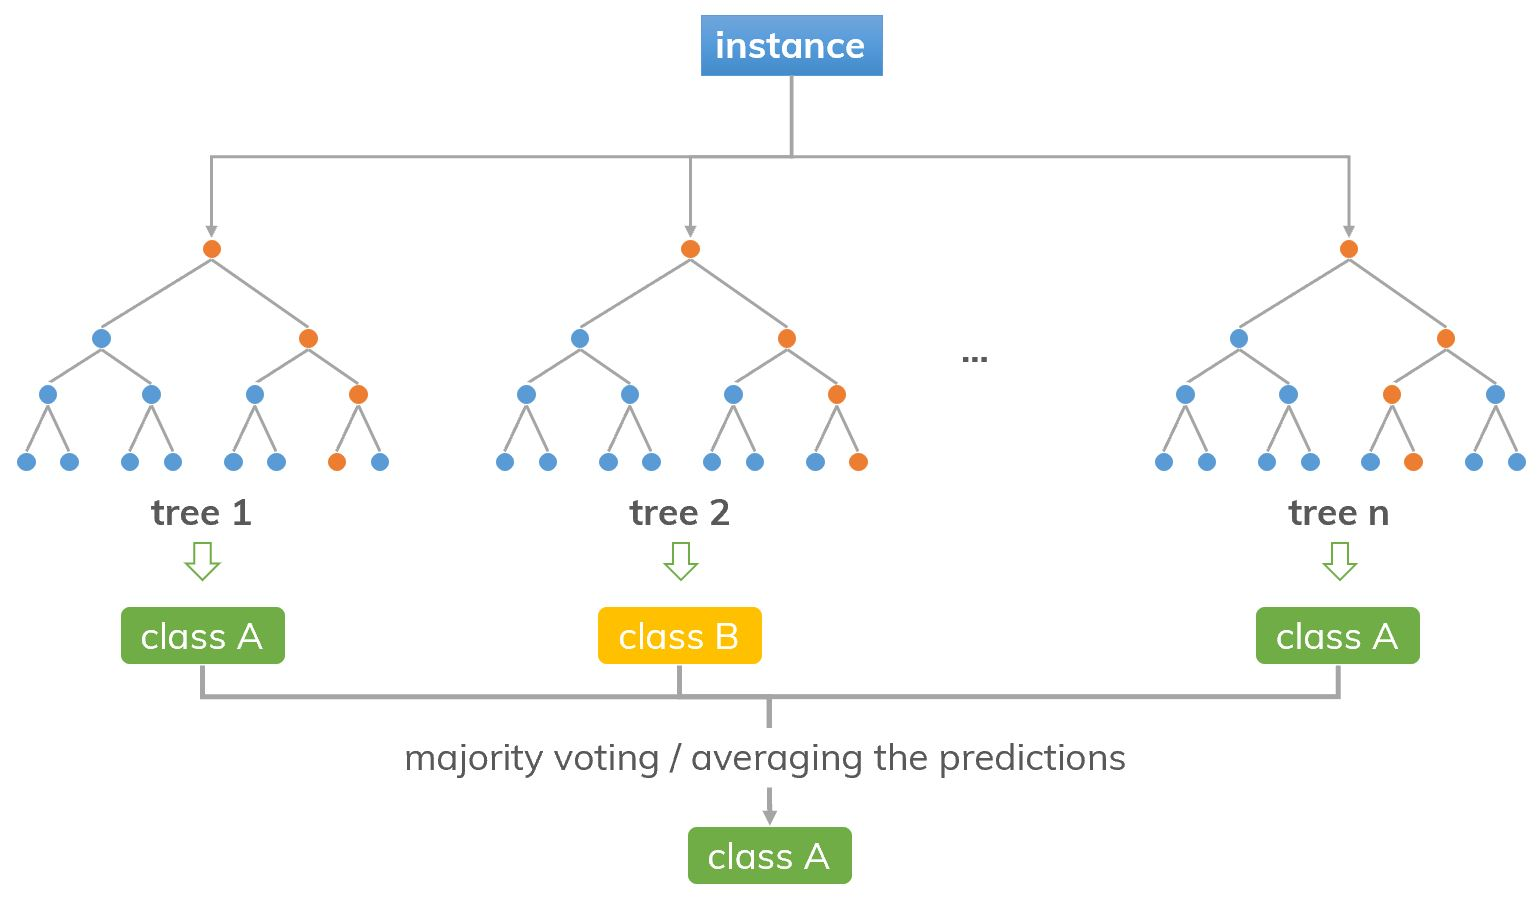

In [ ]:
# This function defines the general pipeline for Random Forest
def random_forest_pipeline(train):
  
  random_forest = RandomForestClassifier(featuresCol="std_features", labelCol="label")

  #### RANDOM FOREST
  param_grid = ParamGridBuilder()\
    .addGrid(random_forest.maxDepth, [3, 5, 7]) \
    .addGrid(random_forest.numTrees, [10, 20, 30]) \
    .build()

  cross_val_rf = CrossValidator(estimator = random_forest, 
                              estimatorParamMaps = param_grid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = 10,
                              collectSubModels = False,
                              parallelism = 2
                              )

  cv_model_rf = cross_val_rf.fit(train)

  return cv_model_rf

In [ ]:
start_time = time.time()
cv_model_genre_rf = random_forest_pipeline(train_set_genre)
end_time = time.time()

In [ ]:
cv_model_genre_rf.write().overwrite().save(PATH_RF_GENRE)

In [ ]:
test_predictions_genre_rf = cv_model_genre_rf.transform(test_set_genre)

test_predictions_genre_rf.select("std_features", "prediction", "label").show(5)

### Multi Layer Perceptrons Network

MLPNs is a supervised machine learning algorithm and it made use of perceptrons. The structure of MLPNs is composed of:
- input layers, 
- hidden layers,  
- output layers.
 
Each layer is fully connected one to the other with a feed-forward activation function. It made use of a **Convolutional function** to "active" or not one node (perceptron). In MLPNs we want that our outputs are closer as possible to the right one, and so we have to iteratively adjust the weights of each edge.

An example of an MLPN is provided in the figure below.

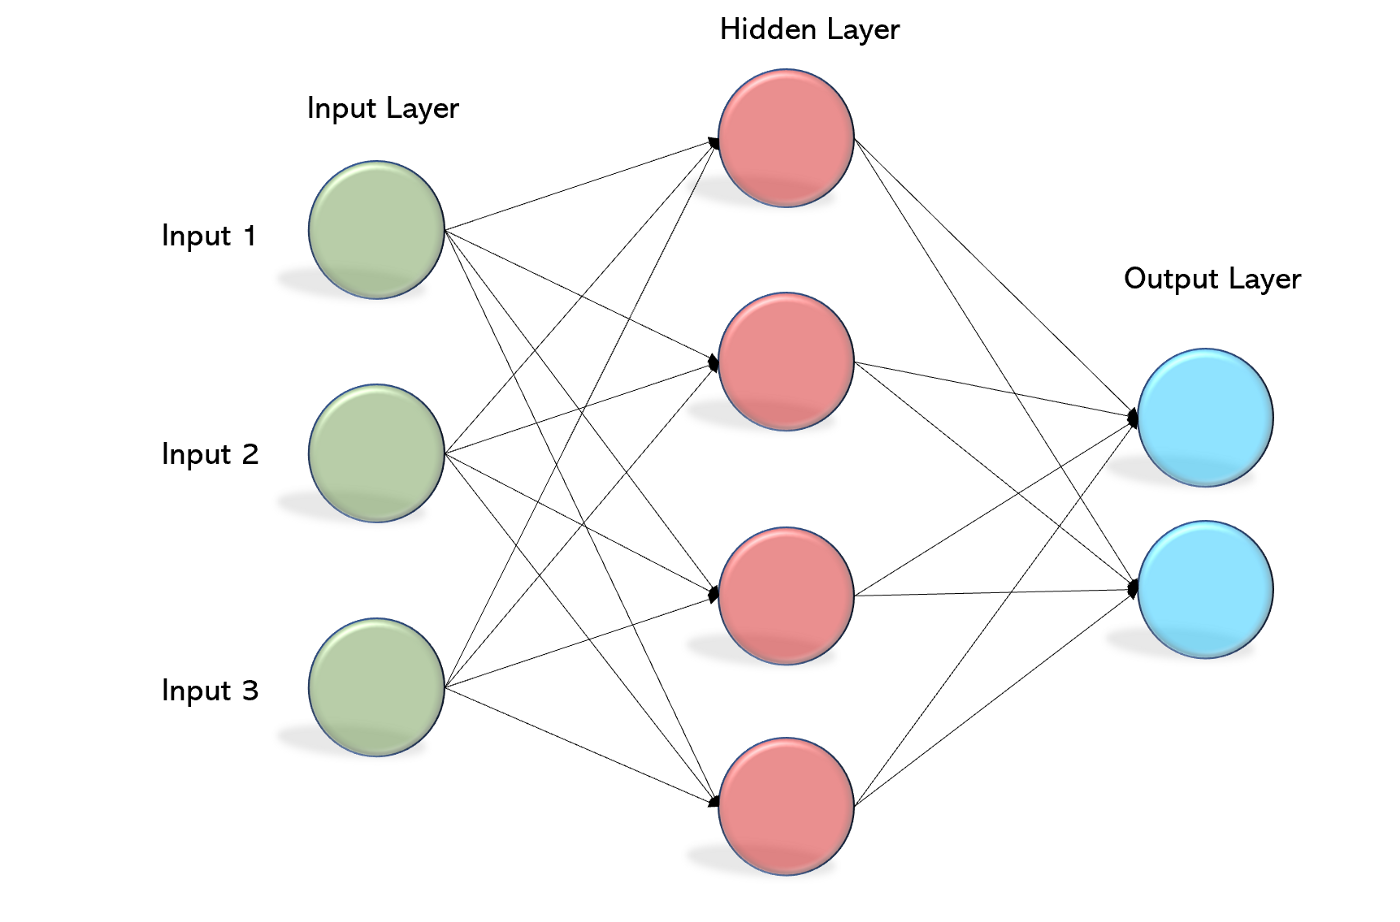

In [ ]:
# This function defines the general pipeline for MLPN
def multi_layer_perceptron_pipeline(train, genre_popularity):
  
  multi_layer_perceptron = MultilayerPerceptronClassifier(featuresCol="std_features", labelCol="label")

  layers_list = []
  # Input and output layers must be equale to the number of features and classes respectivly
  
  # if True it is for genre
  if genre_popularity:
    layers_list = [[46, 50, 11], [46, 30, 11]]
  # if False is for popularity
  else:
    layers_list = [[46, 50, 4], [46, 30, 4]]

  #### MULTI LAYER PERCEPTRON
  param_grid = ParamGridBuilder()\
    .addGrid(multi_layer_perceptron.layers, layers_list) \
    .addGrid(multi_layer_perceptron.seed, [0, 123]) \
    .build()

  cross_val_mlp = CrossValidator(estimator = multi_layer_perceptron, 
                              estimatorParamMaps = param_grid,
                              evaluator = MulticlassClassificationEvaluator(),
                              numFolds = 5,
                              collectSubModels = False,
                              parallelism = 2
                              )

  cv_model_mlp = cross_val_mlp.fit(train)

  return cv_model_mlp

In [ ]:
start_time = time.time()
cv_model_genre_mlp = multi_layer_perceptron_pipeline(train_set_genre, True)
end_time = time.time()

In [ ]:
cv_model_genre_mlp.write().overwrite().save(PATH_MLP_GENRE)

In [ ]:
test_predictions_genre_mlp = cv_model_genre_mlp.transform(test_set_genre)

test_predictions_genre_mlp.select("std_features", "prediction", "label").show(5)

## Regressor
Machine learning regression models are mainly used in predictive analytics to forecast trends and predict outcomes. Regression models will be trained to understand the relationship between different independent variables and an outcome. The model can therefore understand the many different factors which may lead to a desired outcome. The resulting models can be used in a range of ways and in a variety of settings. Outcomes can be predicted from new and unseen data, market fluctuations can be predicted and accounted for, and campaigns can be tested by tweaking different independent variables. 


### **Decision Tree Regressor**
Regression trees handle both continuous features and non-categorical classification functions.
Regression trees output values, therefore they are regressors, as the name says, not classifiers.

In Dtrees we can discretize features, but this is part of data pre-processing.
In RT, creating splits on continuous features is part of the learning process (RT parameters).
Every branch of the tree defines a region in the multi-dimensional space, the output (leaf nodes of the tree) is the mean value of the output of training data in the defined region.
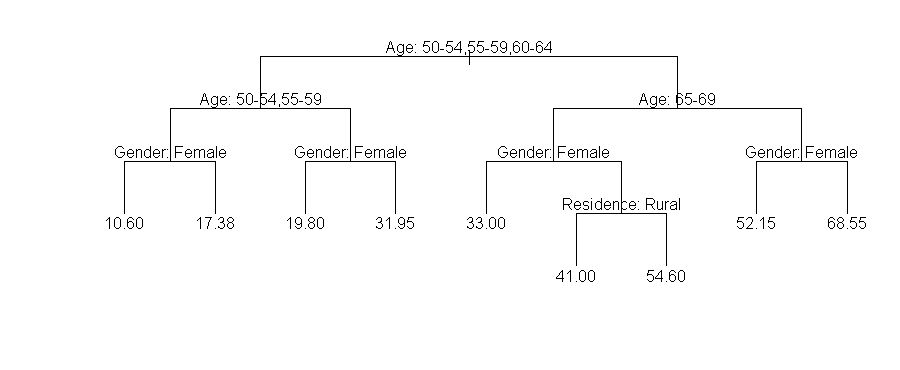

In [ ]:
# This function defines the general pipeline for decision tree regressor
def decision_tree_regressor(train):
  
  decision_tree = DecisionTreeRegressor(featuresCol='std_features',labelCol='label')

  #### DECISION TREE
  param_grid = ParamGridBuilder()\
    .addGrid(decision_tree.maxDepth, [5, 7, 10]) \
    .build()
  cross_val_dt = CrossValidator(estimator = decision_tree,
                                estimatorParamMaps = param_grid,
                                evaluator = RegressionEvaluator(),
                                numFolds = 5,
                                collectSubModels = False,
                                parallelism = 2
                                )
  
  cv_model_dt = cross_val_dt.fit(train)

  return cv_model_dt

In [ ]:
start_time = time.time()
cv_model_popularity_dt = decision_tree_regressor(train_set_popularity)
end_time = time.time()

print("Time Required: %s seconds" % (end_time - start_time))

Time Required: 1104.956304550171 seconds


In [ ]:
cv_model_popularity_dt.write().overwrite().save(PATH_DT_POPULARITY)

In [ ]:
test_predictions_popularity_dt = cv_model_popularity_dt.transform(test_set_popularity)

test_predictions_popularity_dt.select("std_features", "prediction", "label").show(5)

+--------------------+------------------+-----+
|        std_features|        prediction|label|
+--------------------+------------------+-----+
|[-1.5343601458271...| 26.10979228486647|    0|
|[-1.4093773562056...| 15.92156862745098|    0|
|[-1.3370188990563...|18.273311897106108|    3|
|[-0.8873439780814...| 16.35532994923858|   17|
|[-0.7199986008199...| 26.10979228486647|    0|
+--------------------+------------------+-----+
only showing top 5 rows



### **Linear Regression**
Linear regression is perhaps one of the most well known and well understood algorithms in statistics and machine learning.
Linear regression is a linear model, e.g. a model that assumes a linear relationship between the input variables (x) and the single output variable (y). More specifically, that y can be calculated from a linear combination of the input variables (x).
The representation is a linear equation that combines a specific set of input values (x) the solution to which is the predicted output for that set of input values (y). As such, both the input values (x) and the output value are numeric.
The linear equation assigns one scale factor to each input value or column, called a coefficient and represented by the capital Greek letter Beta (B). One additional coefficient is also added, giving the line an additional degree of freedom (e.g. moving up and down on a two-dimensional plot) and is often called the intercept or the bias coefficient.
For example, in a simple regression problem (a single x and a single y), the form of the model would be:

y = B0 + B1*x

In [ ]:
# This function defines the general pipeline for decision tree
def linear_regressor(train):
  
  linear_r = LinearRegression(featuresCol='std_features',labelCol='label')

  #### DECISION TREE
  param_grid = ParamGridBuilder()\
    .addGrid(linear_r.regParam, [0.0, 0.1, 1.0]) \
    .addGrid(linear_r.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(linear_r.maxIter, [10, 20]) \
    .build()
  cross_val_dt = CrossValidator(estimator = linear_r,
                                estimatorParamMaps = param_grid,
                                evaluator = RegressionEvaluator(),
                                numFolds = 5,
                                collectSubModels = False,
                                parallelism = 2
                                )
  
  cv_model_dt = cross_val_dt.fit(train)

  return cv_model_dt

In [ ]:
start_time = time.time()
cv_model_popularity_lr = linear_regressor(train_set_popularity)
end_time = time.time()

print("Time Required: %s seconds" % (end_time - start_time))

Time Required: 1416.5298948287964 seconds


In [ ]:
cv_model_popularity_lr.write().overwrite().save(PATH_LN_POPULARITY)

In [ ]:
test_predictions_popularity_lr = cv_model_popularity_lr.transform(test_set_popularity)

test_predictions_popularity_lr.select("std_features", "prediction", "label").show(5)

+--------------------+------------------+-----+
|        std_features|        prediction|label|
+--------------------+------------------+-----+
|[-1.5343601458271...| 21.41110062494154|    0|
|[-1.4093773562056...|17.570067331018375|    0|
|[-1.3370188990563...| 15.86558087396274|    3|
|[-0.8873439780814...| 12.70904230311805|   17|
|[-0.7199986008199...|24.499996540542085|    0|
+--------------------+------------------+-----+
only showing top 5 rows



# Evaluation

## Classifier

In ML we have different metrics that we can use to discuss performance metrics of our model, in classification task there are:
- **Accuracy**: the number of correct predictions over all the predictions made;

  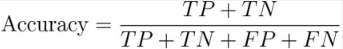

- **Precision or Positive Predictive Value (PPV)**: the number of correctly predicted positive instances over all the positive predictions made;

  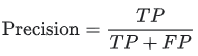

- **Recall or Sensitivity**:  The number of correctly predicted positive instances over all the actually positive existing instaces;

  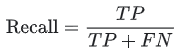

- **F1 Score**: The F1 score is the harmonic mean of the precision and recall.

  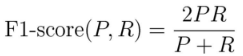

Accuracy in this case is a good measure because the target variable classes in the dataset are balanced.

Precision gives us information about model performance with respect to False Positives, while Recall gives us information about model performance with respect to False Negative.

In [55]:
# Here we define a function to evalute the results of our models
def evaluate_cl(cv_model, test_prediction):

  #for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
  #    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

  print("\n", cv_model.bestModel, "\n")

  print("######################### Test Set #########################")
  evaluator = cv_model.getEvaluator()
  print('Test F1-Score ',   evaluator.evaluate(test_prediction, {evaluator.metricName: 'f1'}))
  print('Test Precision ',  evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedPrecision'}))
  print('Test Recall ',     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedRecall'}))
  print('Test Accuracy ',   evaluator.evaluate(test_prediction, {evaluator.metricName: 'accuracy'}))
  print("############################################################")

  # We will then use this to make the comparison plots between the various models
  evaluation_list = [evaluator.evaluate(test_prediction, {evaluator.metricName: 'f1'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedPrecision'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'weightedRecall'}),
                     evaluator.evaluate(test_prediction, {evaluator.metricName: 'accuracy'})]

  return evaluation_list

### Decision Tree

In [58]:
cv_model_genre_dt = CrossValidatorModel.load(PATH_DT_GENRE)
test_predictions_genre_dt = cv_model_genre_dt.transform(test_set_genre)

test_predictions_genre_dt.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5343601458271...|       7.0|  7.0|
|[-1.4093773562056...|       9.0|  9.0|
|[-1.3370188990563...|       7.0|  1.0|
|[-0.8873439780814...|       8.0|  8.0|
|[-0.7199986008199...|      10.0| 10.0|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
# Here we print the best model according to k-fold cross validation for the genre
print("Best model according to k-fold cross validation:", 
      " maxDept=", cv_model_genre_dt.bestModel.getMaxDepth(),
      " impurity=", cv_model_genre_dt.bestModel.getImpurity())

el_genre_dt = evaluate_cl(cv_model_genre_dt, test_predictions_genre_dt)

Best model according to k-fold cross validation:  maxDept= 7  impurity= entropy

 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_6d464f164e12, depth=7, numNodes=221, numClasses=11, numFeatures=46 

######################### Test Set #########################
Test F1-Score  0.3862080368875714
Test Precision  0.4336352655234839
Test Recall  0.3867259918427883
Test Accuracy  0.3867259918427883
############################################################


### Logistic Regression

In [59]:
cv_model_genre_lg = CrossValidatorModel.load(PATH_LG_GENRE)
test_predictions_genre_lg = cv_model_genre_lg.transform(test_set_genre)

test_predictions_genre_lg.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5343601458271...|       7.0|  7.0|
|[-1.4093773562056...|       9.0|  9.0|
|[-1.3370188990563...|       1.0|  1.0|
|[-0.8873439780814...|       8.0|  8.0|
|[-0.7199986008199...|      10.0| 10.0|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
# Here we print the best model according to k-fold cross validation for the genre
print("Best model according to k-fold cross validation:", 
      " regParam=", cv_model_genre_lg.bestModel.getRegParam(),
      " elasricNetParam=", cv_model_genre_lg.bestModel.getElasticNetParam(),
      " maxIter=", cv_model_genre_lg.bestModel.getMaxIter)

el_genre_lg = evaluate_cl(cv_model_genre_lg, test_predictions_genre_lg)

Best model according to k-fold cross validation:  regParam= 0.0  elasricNetParam= 0.0  maxIter= <bound method HasMaxIter.getMaxIter of LogisticRegressionModel: uid=LogisticRegression_9c55a6dfd895, numClasses=11, numFeatures=46>

 LogisticRegressionModel: uid=LogisticRegression_9c55a6dfd895, numClasses=11, numFeatures=46 

######################### Test Set #########################
Test F1-Score  0.42620030611768006
Test Precision  0.46738555450339436
Test Recall  0.4590285502410086
Test Accuracy  0.4590285502410085
############################################################


### Random Forest

In [60]:
cv_model_genre_rf = CrossValidatorModel.load(PATH_RF_GENRE)
test_predictions_genre_rf = cv_model_genre_rf.transform(test_set_genre)

test_predictions_genre_rf.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5343601458271...|       7.0|  7.0|
|[-1.4093773562056...|       9.0|  9.0|
|[-1.3370188990563...|       1.0|  1.0|
|[-0.8873439780814...|       8.0|  8.0|
|[-0.7199986008199...|      10.0| 10.0|
+--------------------+----------+-----+
only showing top 5 rows



In [ ]:
# Here we print the best model according to k-fold cross validation for the genre
print("Best model according to k-fold cross validation:", 
      " maxDepth=", cv_model_genre_rf.bestModel.getMaxDepth(),
      " numTrees=", cv_model_genre_rf.bestModel.getNumTrees)

el_genre_rf = evaluate_cl(cv_model_genre_rf, test_predictions_genre_rf)

Best model according to k-fold cross validation:  maxDepth= 7  numTrees= 30

 RandomForestClassificationModel: uid=RandomForestClassifier_ae51d4bddc8c, numTrees=30, numClasses=11, numFeatures=46 

######################### Test Set #########################
Test F1-Score  0.4792259908914606
Test Precision  0.5001344264650643
Test Recall  0.4898034853540971
Test Accuracy  0.4898034853540971
############################################################


### Multi layer Perceptron

In [61]:
cv_model_genre_mlp = CrossValidatorModel.load(PATH_MLP_GENRE) 

test_predictions_genre_mlp = cv_model_genre_mlp.transform(test_set_genre)

test_predictions_genre_mlp.select("std_features", "prediction", "label").show(5)

+--------------------+----------+-----+
|        std_features|prediction|label|
+--------------------+----------+-----+
|[-1.5343601458271...|       7.0|  7.0|
|[-1.4093773562056...|       9.0|  9.0|
|[-1.3370188990563...|       1.0|  1.0|
|[-0.8873439780814...|       8.0|  8.0|
|[-0.7199986008199...|       1.0| 10.0|
+--------------------+----------+-----+
only showing top 5 rows



In [62]:
# Here we print the best model according to k-fold cross validation for the genre
print("Best model according to k-fold cross validation: ", cv_model_genre_mlp.bestModel.getLayers())
el_genre_mlp = evaluate_cl(cv_model_genre_mlp, test_predictions_genre_mlp)

Best model according to k-fold cross validation:  [46, 30, 11]

 MultilayerPerceptronClassificationModel: uid=MultilayerPerceptronClassifier_be7feea44aaf, numLayers=3, numClasses=11, numFeatures=46 

######################### Test Set #########################
Test F1-Score  0.47898817025177276
Test Precision  0.48057559134226885
Test Recall  0.48127549128661473
Test Accuracy  0.48127549128661473
############################################################


#### Confusion Matrix


- **FN**: The False-negative value for a class will be the sum of values of corresponding rows except for the TP value.
- **FP**: The False-positive value for a class will be the sum of values of the corresponding column except for the TP value.
- **TN**: The True Negative value for a class will be the sum of values of all columns and rows except the values of that class that we are calculating the values for.
- **TP**: The True positive value is where the actual value and predicted value are the same.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


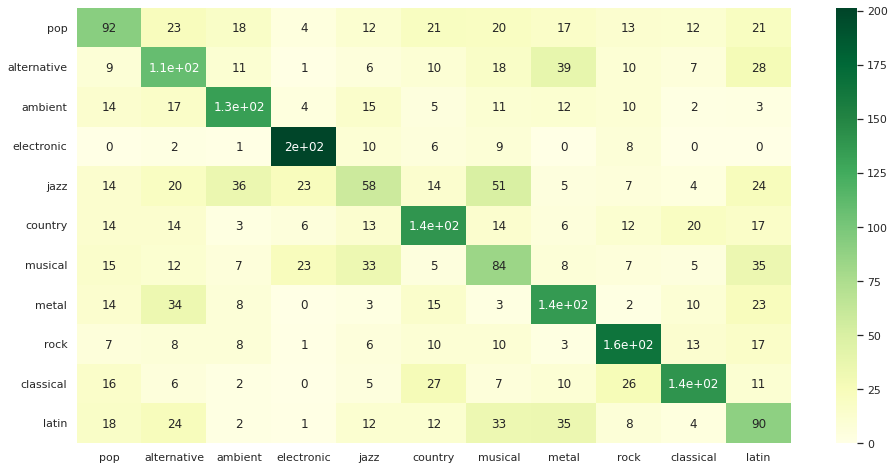

In [ ]:
# Evaluate best model
metrics = MulticlassMetrics(test_predictions_genre_mlp.select("prediction", "label").rdd)

gen = ["pop",	"alternative",	"ambient",	"electronic",	"jazz",	"country",	"musical",	"metal",	"rock",	"classical",	"latin"]

df_cm = pd.DataFrame(metrics.confusionMatrix().toArray(), index = [i for i in gen], columns = [i for i in gen])
plt.figure(figsize = (16,8))
sns.heatmap(df_cm, cmap='YlGn', annot=True)

We can see that the model has struggled to classify "Jazz", making confusion with "Ambient" and "Musical", this is because perhaps Ambient music takes a lot of inspiration from Jazz.

Another observation is the difficulty of distinguishing between "Alternative" and "Metal", it is very predictable as the extremes (heavier for the alternative and lighter for the metal) of the two genres have a lot of similarities.

However, we can see how the "electronic" genre is easily distinguishable from the others, perhaps due to the fact that the tools used are completely different from most of the other classes.

### Models Comparison

In [ ]:
def plot_cl(total_list):
  # List of required attributes
  attributes = ["Decision Tree", "Logistic Regression", "Random Forest", "Multi Layer Perceptron"]

  total_f1, total_wP, total_wR, total_ac = [], [], [], []
    # Arrays used to store the total number of Boolean values for each feature
  for i in range(16):
    if i%4 == 0:
      total_f1.append(total_list[i])
    if i%4 == 1:
      total_wP.append(total_list[i])
    if i%4 == 2:
      total_wR.append(total_list[i])
    if i%4 == 3:
      total_ac.append(total_list[i])

  # Declaring the figure or the plot (y, x) or (width, height)
  plt.figure(figsize=[30, 10])

  # Using numpy to group different data with bars
  number_list = np.arange(len(total_f1))

  for attribute in attributes:
      plt.bar(number_list, total_f1, color = '#4b917d', width = 0.20)
      plt.bar(number_list + 0.20, total_wP, color = '#f037a5', width = 0.20)
      plt.bar(number_list + 0.40, total_wR, color = '#cdf564', width = 0.20)
      plt.bar(number_list + 0.60, total_ac, color = '#191414', width = 0.20)
      
  # Creating the legend of the bars in the plot
  plt.legend(['f1', 'weightedPrecision', 'weightedRecall', 'accuracy'])

  # Overiding the x axis with the feature names
  plt.xticks([i + 0.30 for i in range(len(attributes))], attributes)

  # Giving the tilte for the plot
  plt.title("Model Comparison")

  # Namimg the x and y axis
  plt.xlabel('Model')
  plt.ylabel('Tot')

  # Displaying the bar plot
  plt.show()

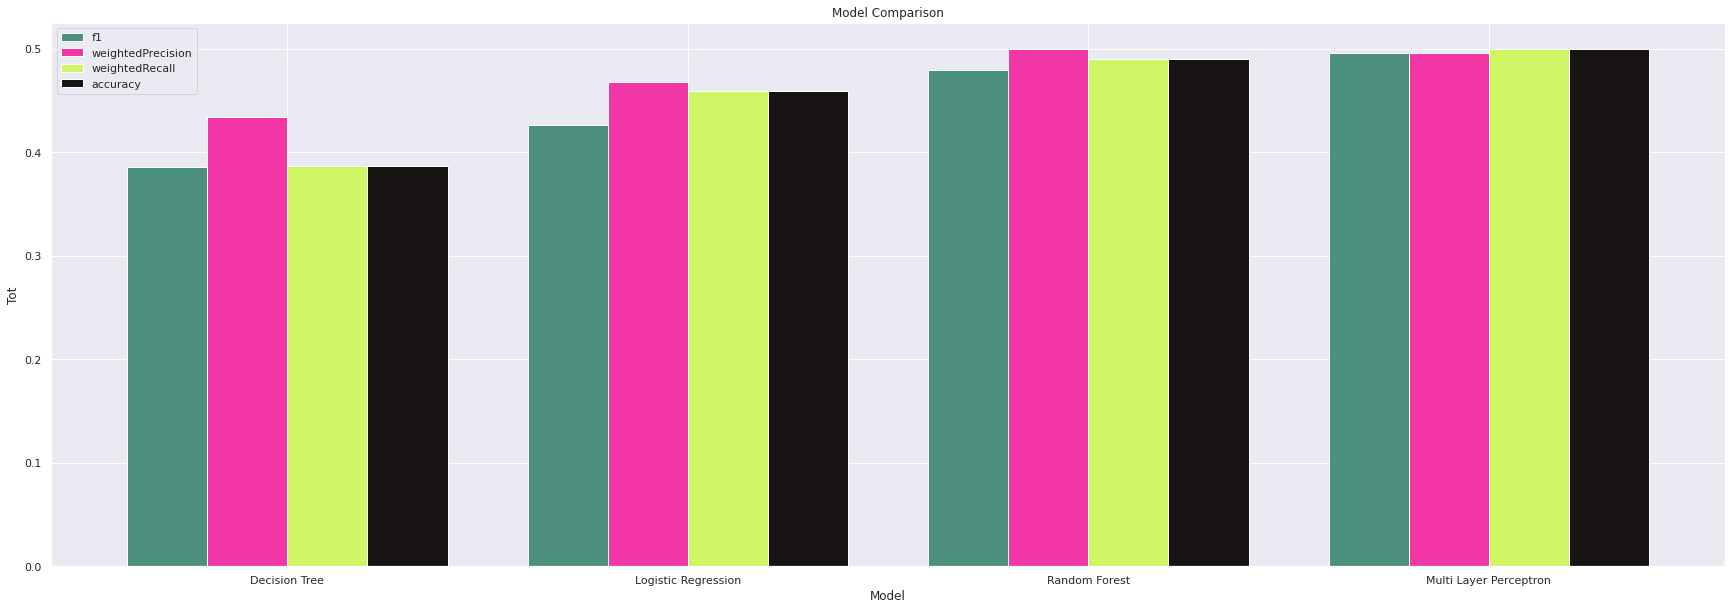

In [ ]:
total_genre_list = el_genre_dt + el_genre_lg + el_genre_rf + el_genre_mlp
plot_cl(total_genre_list)

## **Regressor**

**Error Metrics**

There are four error metrics that are commonly used for evaluating and reporting the performance of a regression model; they are:
* **Mean Absolute Error (MAE)**: It is the average of the absolute differences between the actual value and the model’s predicted value. 
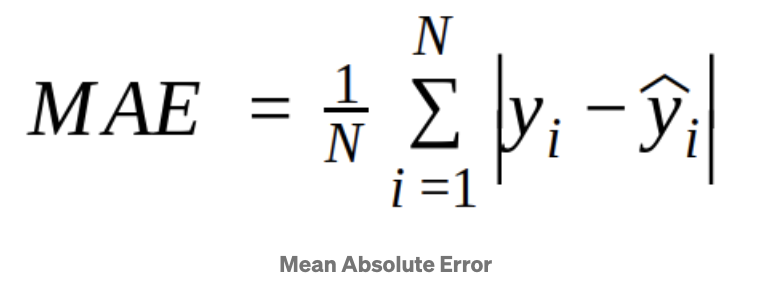

where,
  - `N` = total number of data points
  - `Yi` = actual value
  - `Ŷi` = predicted value

  If we don’t take the absolute values, then the negative difference will cancel out the positive difference and we will be left with a zero upon summation.
* **Mean Squared Error (MSE)**: It is the average of the squared differences between the actual and the predicted values.
Lower the value, the better the regression model.

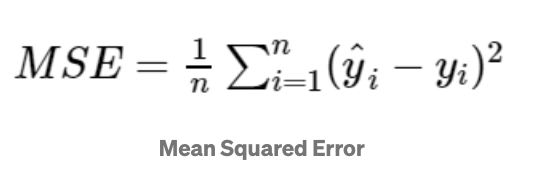

where,
  - `n` = total number of data points
  - `yi` = actual value
  - `ŷi` = predicted value

  Its unit is the square of the variable’s unit.
* **Root Mean Squared Error (RMSE)**: It is the average root-squared difference between the real value and the predicted value. By taking a square root of MSE, we get the Root Mean Square Error.
We want the value of RMSE to be as low as possible, as lower the RMSE value is, the better the model is with its predictions. A Higher RMSE indicates that there are large deviations between the predicted and actual value.

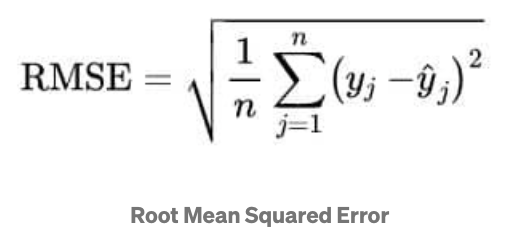

where,
  - `n` = total number of data points
  - `yi` = actual value
  - `ŷi` = predicted value
* **R² score**: R-squared explains to what extent the variance of one variable explains the variance of the second variable. In other words, it measures the proportion of variance of the dependent variable explained by the independent variable.
R squared is a popular metric for identifying model accuracy. It tells how close are the data points to the fitted line generated by a regression algorithm. A larger R squared value indicates a better fit. This helps us to find the relationship between the independent variable towards the dependent variable.
It is the ratio of the sum of squares and the total sum of squares
where SSE is the sum of the square of the difference between the actual value and the predicted value
and, SST is the total sum of the square of the difference between the actual value and the mean of the actual value.

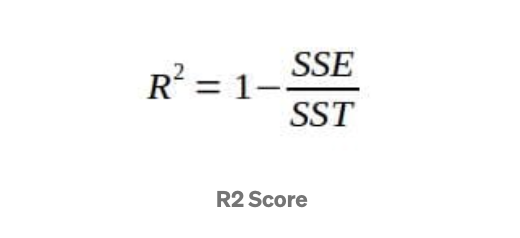

In [ ]:
# Here we define a function to evalute the results of our models
def evaluate_rg(cv_model, test_prediction):

  print("\n", cv_model.bestModel, "\n")

  evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

  # We will then use this to make the comparison plots between the various models
  evaluation_list = [evaluator.evaluate(test_prediction,{evaluator.metricName: "r2"}),
                     evaluator.evaluate(test_prediction,{evaluator.metricName: "mse"}),
                     evaluator.evaluate(test_prediction,{evaluator.metricName: "rmse"}),
                     evaluator.evaluate(test_prediction,{evaluator.metricName: "mae"}) ]

  print("######################### Test Set #########################")
  print("r2:", evaluation_list[0])
  print("mse: ", evaluation_list[1])
  print("rmse: ", evaluation_list[2])
  print("mae: ", evaluation_list[3])
  print("############################################################")

  return evaluation_list

### Decision Tree 

In [ ]:
cv_model_popularity_dt = CrossValidatorModel.load(PATH_DT_POPULARITY)
test_predictions_popularity_dt = cv_model_popularity_dt.transform(test_set_popularity)

test_predictions_popularity_dt.select("std_features", "prediction", "label").show(5)

+--------------------+------------------+-----+
|        std_features|        prediction|label|
+--------------------+------------------+-----+
|[-1.5343601458271...| 26.10979228486647|    0|
|[-1.4093773562056...| 15.92156862745098|    0|
|[-1.3370188990563...|18.273311897106108|    3|
|[-0.8873439780814...| 16.35532994923858|   17|
|[-0.7199986008199...| 26.10979228486647|    0|
+--------------------+------------------+-----+
only showing top 5 rows



In [ ]:
# Here we print the best model according to k-fold cross validation for the genre
print("Best model according to k-fold cross validation:", 
      " maxDept=", cv_model_popularity_dt.bestModel.getMaxDepth())

ev_list_dtr = evaluate_rg(cv_model_popularity_dt, test_predictions_popularity_dt)

Best model according to k-fold cross validation:  maxDept= 5

 DecisionTreeRegressionModel: uid=DecisionTreeRegressor_b8bdf2642c7d, depth=5, numNodes=63, numFeatures=46 

######################### Test Set #########################
r2: 0.1143390412148676
mse:  401.33180808366177
rmse:  20.033267533871296
mae:  16.590165204389223
############################################################


### Linear Regression

In [ ]:
cv_model_popularity_lr = CrossValidatorModel.load(PATH_LN_POPULARITY)
test_predictions_popularity_lr = cv_model_popularity_lr.transform(test_set_popularity)

test_predictions_popularity_lr.select("std_features", "prediction", "label").show(5)

+--------------------+------------------+-----+
|        std_features|        prediction|label|
+--------------------+------------------+-----+
|[-1.5343601458271...| 21.41110062494154|    0|
|[-1.4093773562056...|17.570067331018375|    0|
|[-1.3370188990563...| 15.86558087396274|    3|
|[-0.8873439780814...| 12.70904230311805|   17|
|[-0.7199986008199...|24.499996540542085|    0|
+--------------------+------------------+-----+
only showing top 5 rows



In [ ]:
# Here we print the best model according to k-fold cross validation for the genre
print("Best model according to k-fold cross validation:", 
      " regParam=", cv_model_popularity_lr.bestModel.getRegParam(),
      " elasricNetParam=", cv_model_popularity_lr.bestModel.getElasticNetParam(),
      " maxIter=", cv_model_popularity_lr.bestModel.getMaxIter)

ev_list_lrr = evaluate_rg(cv_model_popularity_lr, test_predictions_popularity_lr)

Best model according to k-fold cross validation:  regParam= 0.1  elasricNetParam= 0.5  maxIter= <bound method HasMaxIter.getMaxIter of LinearRegressionModel: uid=LinearRegression_a84c16f17717, numFeatures=46>

 LinearRegressionModel: uid=LinearRegression_a84c16f17717, numFeatures=46 

######################### Test Set #########################
r2: 0.07939494682817749
mse:  417.1665092104829
rmse:  20.42465444531395
mae:  17.302622576846524
############################################################


### Models Comparison

In [ ]:
def plot_rg(total_list):
  # List of required attributes
  attributes = ["Decision Tree", "Linear Regression"]

  total_r2, total_mse, total_rmse, tota_mae = [], [], [], []
    # Arrays used to store the total number of Boolean values for each feature
  for i in range(8):
    if i%4 == 0:
      total_r2.append(total_list[i])
    if i%4 == 1:
      total_mse.append(total_list[i])
    if i%4 == 2:
      total_rmse.append(total_list[i])
    if i%4 == 3:
      tota_mae.append(total_list[i])

  # Declaring the figure or the plot (y, x) or (width, height)
  plt.figure(figsize=[15, 10])

  # Using numpy to group different data with bars
  number_list = np.arange(len(total_r2))

  for attribute in attributes:
      plt.bar(number_list, total_r2, color = '#4b917d', width = 0.20)
      plt.bar(number_list + 0.20, total_mse, color = '#f037a5', width = 0.20)
      plt.bar(number_list + 0.40, total_rmse, color = '#cdf564', width = 0.20)
      plt.bar(number_list + 0.60, tota_mae, color = '#191414', width = 0.20)
      
  # Creating the legend of the bars in the plot
  plt.legend(['r2', 'mse', 'rmse', 'mae'])

  # Overiding the x axis with the feature names
  plt.xticks([i + 0.30 for i in range(len(attributes))], attributes)

  # Giving the tilte for the plot
  plt.title("Model Comparison")

  # Namimg the x and y axis
  plt.xlabel('Model')
  plt.ylabel('Tot')
  plt.yscale('log')

  # Displaying the bar plot
  plt.show()

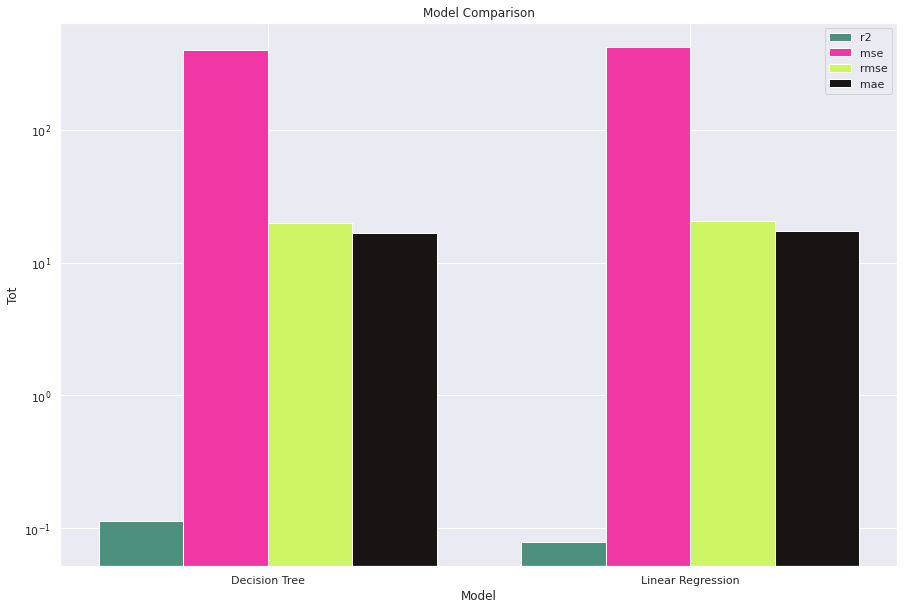

In [ ]:
total_popularity_list = ev_list_dtr + ev_list_lrr
plot_rg(total_popularity_list)

# K-means Clustering

Clustering also called **unsupervised learning**, sometimes called classification by statisticians and sorting by
psychologists and segmentation by people in marketing.

Given a set of points, with a notion of distance (similarity)
between points, group the points into some number of
clusters, so that:
- Members of a cluster are close/similar to each other
- Members of different clusters are dissimilar

K-Means is a special case, where each cluster representative is its center of mass (i.e., centroid).
The centroid of a cluster is the mean of the instances assigned to that cluster

(Re)Assignment of instances to clusters is based on distance/similarity to the current cluster centroids.

The basic idea is constructing clusters so that the total within-cluster _Sum of Square Distances_ (SSD) is minimized.

An example of how k-means works is shown in the figure below.

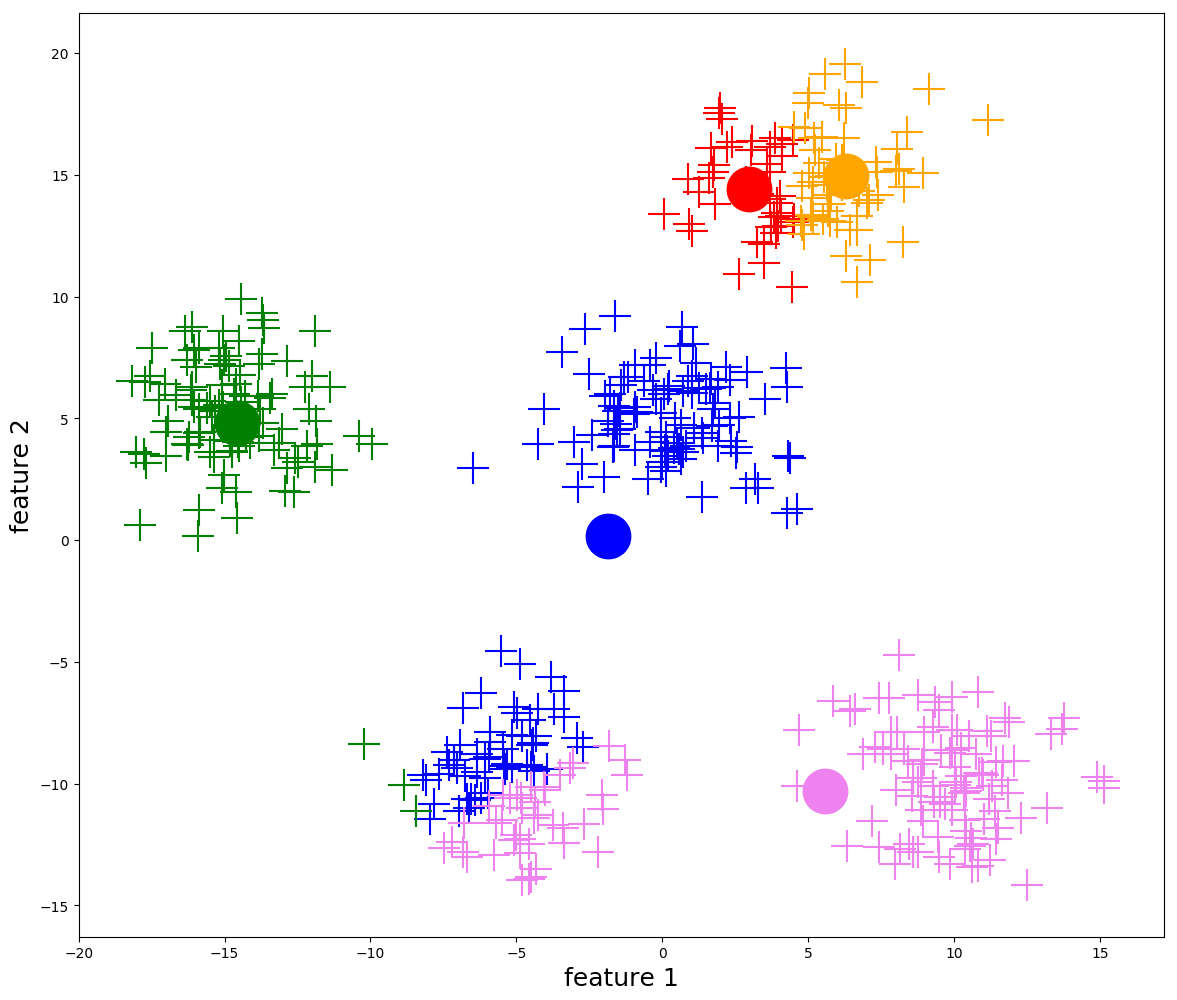

In [ ]:
# We define some parameters for K-means clustering

N_CLUSTERS = 12 # number of output clusters (K)
DISTANCE_MEASURE = "cosine" # alternatively, "cosine" , euclidean
MAX_ITERATIONS = 100 # maximum number of iterations of K-means EM algorithm
TOLERANCE = 0.000001 # tolerance between consecutive centroid updates (i.e., another stopping criterion)

In [ ]:
# We define a function used for running k-means

def k_means (dataset, 
            n_clusters, 
            distance_measure=DISTANCE_MEASURE, 
            max_iter=MAX_ITERATIONS, 
            tol=TOLERANCE,
            features_col="std_features", 
            prediction_col="cluster", 
            random_seed=RANDOM_SEED):

  """
  print('''Training K-means clustering using the following parameters: 
  - K (n. of clusters) = {:d}
  - max_iter (max n. of iterations) = {:d}
  - distance measure = {:s}
  - random seed = {:d}
  '''.format(n_clusters, max_iter, distance_measure, random_seed))
  """
  # Train a K-means model
  kmeans = KMeans(featuresCol=features_col, 
                   predictionCol=prediction_col, 
                   k=n_clusters, 
                   initMode="k-means||", 
                   initSteps=5, 
                   tol=tol, 
                   maxIter=max_iter, 
                   seed=random_seed, 
                   distanceMeasure=distance_measure)
  model = kmeans.fit(dataset)

  # Make clusters
  clusters_df = model.transform(dataset).cache()

  return model, clusters_df

In [ ]:
evaluator = ClusteringEvaluator(metricName="silhouette",
                                distanceMeasure="cosine",
                                predictionCol="cluster",
                                featuresCol="std_features"
                                )
silhoutte_score = []
# Run K-means by calling the function 
for i in range(12, 127, 19):
  model, clusters_df = k_means(spotify_tracks_genre, i, max_iter=MAX_ITERATIONS, distance_measure=DISTANCE_MEASURE)
  score = evaluator.evaluate(clusters_df)
  silhoutte_score.append(score)
  print("Score: ", score, "  Number of Cluster: ", i)

Score:  0.09724667282614559   Number of Cluster:  12
Score:  0.07878683432357012   Number of Cluster:  31
Score:  0.07148019891075275   Number of Cluster:  50
Score:  0.06544057483762354   Number of Cluster:  69
Score:  0.06962370369108403   Number of Cluster:  88
Score:  0.06566796020453328   Number of Cluster:  107
Score:  0.06082714650466544   Number of Cluster:  126


## Evaluate obtained clusters

To evaluate the clusters obtained we use the Silhouette Coefficient, which is a measure for the validation of the consistency within clusters. It ranges between 1 and -1, where a value close to 1 means that the points in a cluster are close to the other points in the same cluster and far from the points of the other clusters.

Text(0, 0.5, 'Silhoutte Score')

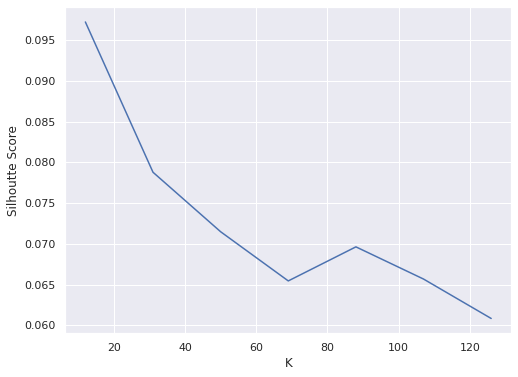

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(range(12, 127, 19), silhoutte_score)
ax.set_xlabel("K")
ax.set_ylabel("Silhoutte Score")

In [ ]:
K=88 # Best value of K (whatever this is!)
print("Running K-means using K = {:d}".format(K))
model, clusters_df = k_means(spotify_tracks_genre, K, max_iter=MAX_ITERATIONS, distance_measure=DISTANCE_MEASURE)
clusters_df.cache()

Running K-means using K = 88


DataFrame[std_features: vector, label: double, cluster: int]

## Inspect some clusters

In [ ]:
clusters_df.groupBy("cluster").count().sort("cluster").show()

+-------+-----+
|cluster|count|
+-------+-----+
|      0|  161|
|      1|  139|
|      2|  135|
|      3|  112|
|      4|  166|
|      5|  128|
|      6|  143|
|      7|  426|
|      8|   91|
|      9|   72|
|     10|  234|
|     11|  174|
|     12|  192|
|     13|  155|
|     14|  137|
|     15|  214|
|     16|  204|
|     17|  161|
|     18|  153|
|     19|  127|
+-------+-----+
only showing top 20 rows



In [ ]:
# Get unique values in the grouping column
clusters = sorted([x[0] for x in clusters_df.select("cluster").distinct().collect()])
#print("Cluster IDs: [{:s}]".format(", ".join([str(c) for c in clusters])))

# Create a filtered DataFrame for each group in a list comprehension
cluster_list = [clusters_df.where(clusters_df.cluster == x) for x in clusters]

# Show the results
for x_id, x in enumerate(cluster_list):
  # most common label
  label = x.groupby('label').count()
  print("Cluster:", x_id, "  Most common label:", label.orderBy(desc('count')).take(1)[0].label)
  #x.select(["cluster", "label", "std_features"]).show(10, truncate=False)

Cluster: 0   Most common label: 2.0
Cluster: 1   Most common label: 0.0
Cluster: 2   Most common label: 1.0
Cluster: 3   Most common label: 9.0
Cluster: 4   Most common label: 8.0
Cluster: 5   Most common label: 10.0
Cluster: 6   Most common label: 4.0
Cluster: 7   Most common label: 3.0
Cluster: 8   Most common label: 3.0
Cluster: 9   Most common label: 9.0
Cluster: 10   Most common label: 3.0
Cluster: 11   Most common label: 10.0
Cluster: 12   Most common label: 7.0
Cluster: 13   Most common label: 0.0
Cluster: 14   Most common label: 0.0
Cluster: 15   Most common label: 9.0
Cluster: 16   Most common label: 1.0
Cluster: 17   Most common label: 5.0
Cluster: 18   Most common label: 10.0
Cluster: 19   Most common label: 10.0
Cluster: 20   Most common label: 4.0
Cluster: 21   Most common label: 1.0
Cluster: 22   Most common label: 3.0
Cluster: 23   Most common label: 8.0
Cluster: 24   Most common label: 4.0
Cluster: 25   Most common label: 4.0
Cluster: 26   Most common label: 8.0
Cluster

# Content-based Filtering Recommendation

The idea is to recommend songs to the user, to be able to insert in their own playlist.
The list of recommended songs is sorted according to the similarity of the songs contained in the playlist given in input.
However, the Spotify Web API does not provide data on other general users but you need to know the user's ID in order to download their public playlists.
Hence it is difficult to obtain large amounts of information about the preferences of other users.
For this reason we have chosen **content-based filtering** to develop this system.

First we choose the playlist from the dataset that was created specifically for it.
We concatenate all the songs in the playlist into a __summary vector__.
Then, we find the similarity between the summarized playlist vector with all the songs (excluding the songs in the playlist) in the database.
Then, we use the **cosine similarity** measure retrieved from the most relevant song that is not in the playlist to recommend it.

Specifically, we decided to use the cosine similarity as unlike the Euclidean similarity which looks at the distance between two points, it looks at the angle between two vectors.
In fact, once the two vectors generally point in the same direction, then they are similar. For this reason the summary vector was constructed by adding the rows and not averaging.


## Upload and Organize Playlist Dataset

### Upload playlist Dataset


In [ ]:
playlist_tracks = spark.read.load(GDRIVE_PLAYLIST_DATASET_FILE, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

In [ ]:
playlist_tracks.show()

+--------------------+-------------------+--------------------+--------------------+--------------+----------------+--------------------+------------------+----------------------------+--------------------+--------------------+--------------------+------------------+------------------+-----------------+------------+----------------------+-----------+--------------+--------------+------------+-----------------+-----------+--------------------+-------------+--------------------+
|         playlist_id|      playlist_name|            track_id|          track_name|track_explicit|track_popularity|          album_name|album_release_date|album_release_date_precision|         artist_name|   audio_avg_pitches|    audio_avg_timbre|audio_acousticness|audio_danceability|audio_duration_ms|audio_energy|audio_instrumentalness|audio_key_1|audio_liveness|audio_loudness|audio_mode_1|audio_speechiness|audio_tempo|audio_time_signature|audio_valence|           track_uri|
+--------------------+--------------

In [ ]:
playlist_tracks.printSchema()

root
 |-- playlist_id: string (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_avg_pitches: string (nullable = true)
 |-- audio_avg_timbre: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- aud

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(playlist_tracks.count(), len(playlist_tracks.columns)))

The shape of the dataset is 130 rows by 26 columns


In [ ]:
# Select the playlist where we want add new songs
playlist_name = "😝Finto Alternativo"
one_playlist_tracks = playlist_tracks.where(playlist_tracks.playlist_name == playlist_name)

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(one_playlist_tracks.count(), len(one_playlist_tracks.columns)))

The shape of the dataset is 100 rows by 26 columns


In [ ]:

# Split Array Columns
one_playlist_tracks_splitted = split_array_columns(one_playlist_tracks, "audio_avg_pitches", "pitch_")
one_playlist_tracks_splitted = split_array_columns(one_playlist_tracks_splitted, "audio_avg_timbre", "timbre_")

# Split Date Columns
one_playlist_tracks = split_date(one_playlist_tracks_splitted, "album_release_date")
del one_playlist_tracks_splitted

In [ ]:
# Delete columns
cols = ("playlist_id", "playlist_name", "track_uri")
one_playlist_tracks = one_playlist_tracks.drop(*cols)

In [ ]:
one_playlist_tracks.printSchema()

root
 |-- track_id: string (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_explicit: boolean (nullable = true)
 |-- track_popularity: integer (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_release_date_precision: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- audio_acousticness: double (nullable = true)
 |-- audio_danceability: double (nullable = true)
 |-- audio_duration_ms: integer (nullable = true)
 |-- audio_energy: double (nullable = true)
 |-- audio_instrumentalness: double (nullable = true)
 |-- audio_key_1: integer (nullable = true)
 |-- audio_liveness: double (nullable = true)
 |-- audio_loudness: double (nullable = true)
 |-- audio_mode_1: integer (nullable = true)
 |-- audio_speechiness: double (nullable = true)
 |-- audio_tempo: double (nullable = true)
 |-- audio_time_signature: integer (nullable = true)
 |-- audio_valence: double (nullable = true)
 |-- pitch_0: double (nullable = true)
 |-- pitch_1: 

In [ ]:
# Save datset as file to save memory 
playlist = one_playlist_tracks.toPandas()
playlist.to_csv("pandas_playlist.csv")


### Clean and organize the two dataset


In [ ]:
# Upload dataset
playlist= spark.read.load("pandas_playlist.csv", format="csv", sep=",", inferSchema="true",header="true") 
all_tracks = spark.read.load("full_pandas_all_tracks.csv", format="csv", sep=",", inferSchema="true",header="true") # Full
all_tracks = all_tracks.withColumnRenamed("id","track_id")

all_tracks_original = all_tracks.alias('all_tracks_original')
all_tracks_original = all_tracks_original.withColumnRenamed("id","track_id")

In [ ]:
print("The shape of the 'all_tracks' dataset is {:d} rows by {:d} columns".format(all_tracks.count(), len(all_tracks.columns)))

print("The shape of the 'playlist' dataset is {:d} rows by {:d} columns".format(playlist.count(), len(playlist.columns)))

The shape of the 'all_tracks' dataset is 56000 rows by 49 columns
The shape of the 'playlist' dataset is 100 rows by 48 columns


In [ ]:
# Drop album_release_date_precision because is redundant
playlist = playlist.drop("album_release_date_precision")
all_tracks = all_tracks.drop("album_release_date_precision")

# Drop also genre from all_tracks
all_tracks = all_tracks.drop("track_genre")

### Preprocessing the two dataset 

In [ ]:
# get categorical Features
playlist_cat = [item[0] for item in playlist.dtypes if item[1].startswith('string')]
all_tracks_cat = [item[0] for item in all_tracks.dtypes if item[1].startswith('string')]

print(playlist_cat)
print(all_tracks_cat)

['track_id', 'track_name', 'album_name', 'artist_name']
['track_id', 'track_name', 'track_explicit', 'track_popularity', 'album_name', 'artist_name', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10']


In [ ]:
# Cast to correct value
for col in playlist.dtypes:
  col_type = col[1]
  if col_type != all_tracks.schema[col[0]].dataType:
    all_tracks = all_tracks.withColumn(col[0], all_tracks[col[0]].cast(col[1]))


In [ ]:
# Check the changes
playlist_cat = [item[0] for item in playlist.dtypes if item[1].startswith('string')]
all_tracks_cat = [item[0] for item in all_tracks.dtypes if item[1].startswith('string')]

# We do not want the encoding of id beacause we need it later
playlist_cat.remove("track_id")
all_tracks_cat.remove("track_id")

print(playlist_cat)
print(all_tracks_cat)

['track_name', 'album_name', 'artist_name']
['track_name', 'album_name', 'artist_name']


In [ ]:
# Cast Bool to Int
playlist = playlist.withColumn("track_explicit", playlist["track_explicit"].cast("int"))
all_tracks = all_tracks.withColumn("track_explicit", all_tracks["track_explicit"].cast("int"))

In [ ]:
# Drop null
all_tracks = all_tracks.dropna()

In [ ]:
CATEGORICAL_FEATURES, NUMERICAL_FEATURES = get_features_type(spotify_tracks_genre, "")
CATEGORICAL_FEATURES.remove("track_id")
NUMERICAL_FEATURES.remove("_c0")

Categorical Dataset:  ['track_name', 'album_name', 'artist_name']
Numerical Dataset:  ['track_explicit', 'track_popularity', 'audio_acousticness', 'audio_danceability', 'audio_duration_ms', 'audio_energy', 'audio_instrumentalness', 'audio_key_1', 'audio_liveness', 'audio_loudness', 'audio_mode_1', 'audio_speechiness', 'audio_tempo', 'audio_time_signature', 'audio_valence', 'pitch_0', 'pitch_1', 'pitch_2', 'pitch_3', 'pitch_4', 'pitch_5', 'pitch_6', 'pitch_7', 'pitch_8', 'pitch_9', 'pitch_10', 'pitch_11', 'timbre_0', 'timbre_1', 'timbre_2', 'timbre_3', 'timbre_4', 'timbre_5', 'timbre_6', 'timbre_7', 'timbre_8', 'timbre_9', 'timbre_10', 'timbre_11', 'day', 'month', 'year']


In [ ]:
playlist.cache()

# Apply Pipeline to Encode dataset 
playlist = to_numerical(playlist, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)

playlist = playlist.select(["track_id", "std_features"])
playlist.show(truncate=False)

+----------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id              |std_features                                              

In [ ]:
all_tracks.cache()

# Apply Pipeline to Encode dataset 
all_tracks = to_numerical(all_tracks, NUMERICAL_FEATURES, CATEGORICAL_FEATURES)


all_tracks = all_tracks.select(["track_id", "std_features"])
all_tracks.show(truncate=False)

+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id              |std_features                                       

## Extract features
The next step is to generate the summary vector. We need to first use the id to differentiate songs that are in the playlist and those that are not. Then, we simply add the features for all songs in the playlist together as a summary vector.

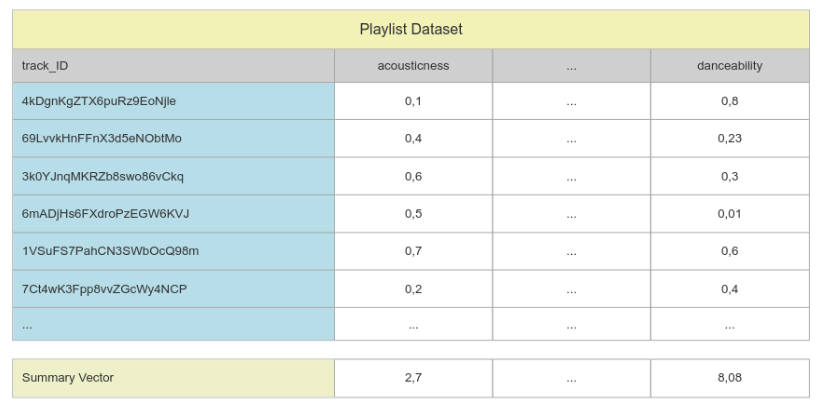

In [ ]:
def generate_playlist_vector(tracks, playlist):
    """
    Input: 
    tracks: datset of the all tracks
    playlist: dataset of the selected playlist
        
    Output: 
    playlist_vector: single vector feature that summarizes the playlist
    tracks_nonplaylist: 
    """
    
    # Find song features in the playlist
    # Create a DataSet containing only the IDs in both
    list_id = [row[0] for row in playlist.select('track_id').collect()]
    tracks_playlist = tracks.filter(tracks.track_id.isin(list_id))

    # Find all non-playlist song features  
    # Create a DataSet containing only the IDs present exclusively in 'trcks'
    tracks_nonplaylist = tracks.filter(~tracks.track_id.isin(list_id))

    tracks_playlist_final = tracks_playlist.drop("track_id")

    row_list = tracks_playlist_final.collect()
    print(row_list)
    playlist_vector = [0 for i in range(45)]
    for row in row_list:
      array = row.__getitem__('std_features').values
      playlist_vector =  [x + y for x, y in zip(playlist_vector, array)]

    return playlist_vector, tracks_nonplaylist

In [ ]:
# Generate the features
playlist_vector, tracks_nonplaylist = generate_playlist_vector(all_tracks, playlist)

[Row(std_features=DenseVector([-1.2782, -0.8661, -0.7469, -0.2509, -0.7738, -0.6965, 0.3312, -0.4628, 0.7279, -0.6015, 1.0237, -0.8757, 0.3052, 0.7685, -0.4591, 0.1067, 0.207, 1.1256, -0.2848, -0.2226, -0.4136, -0.2723, 1.2488, -0.7748, -0.0292, -0.4333, 1.038, 1.4149, 0.0677, 1.2307, 0.6844, 0.5279, 0.1453, -0.5939, -0.9791, -0.1438, -0.3536, 0.2204, 0.1022, 0.854, 0.3535, -0.9862, -1.0369, -1.0676, -0.4815])), Row(std_features=DenseVector([-1.3714, -0.8823, -0.6728, -0.2509, -0.7738, -0.6965, -0.8245, -0.5133, 0.4862, -0.6015, 0.1827, 0.7393, 0.3411, -1.3012, -0.4592, -0.3025, 0.207, 0.6888, 0.0882, 0.9049, 0.2223, -0.7088, -0.7741, -0.5782, 1.1707, -0.8021, -0.919, -0.5148, -0.6597, 0.3662, 0.8532, 0.0377, 0.2681, -0.8293, -0.8185, -0.0488, 0.4775, 0.9832, -0.1329, 0.3297, 0.1776, -0.0627, -0.2393, 1.0807, 0.7029])), Row(std_features=DenseVector([1.0559, -0.7334, -0.7469, 3.985, 2.3836, -0.6965, -0.23, -0.9184, -1.8907, -0.6015, 0.463, 0.574, 0.4848, 0.7685, -0.4567, 1.746, 0.207, -

In [ ]:
tracks_nonplaylist.show(truncate=False)

+----------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|track_id              |std_features                                       

In [ ]:
# Summarized playlist features
playlist_vector

[-4.200521030150989,
 -5.8011996255713445,
 -7.186652249379874,
 5.9624541710222765,
 14.22230676144746,
 -6.390881633564703,
 -3.208913589246871,
 -6.074836517167825,
 4.46589181808897,
 -6.015203938593166,
 -3.498743335706376,
 2.686700760601024,
 6.008996426110455,
 5.6156032557253335,
 -4.588022661978609,
 1.4659196236399823,
 2.0704004443597994,
 4.3741258559387415,
 3.3740939348721612,
 0.05034854283774659,
 1.6544516705578118,
 3.947642321187863,
 3.3573545535503335,
 1.5966676428929447,
 1.8817542820505986,
 3.335281308885509,
 3.9904947018410293,
 1.085246950084816,
 4.529205615182219,
 2.089684918248877,
 7.938197056475819,
 3.6215020837953023,
 2.6651212566975904,
 -4.206788154444851,
 -6.398642697764439,
 -1.999136470840053,
 5.504029176804647,
 3.5428708076426316,
 -1.674417240509698,
 4.635202888186025,
 1.601652190787646,
 -5.1833578229024475,
 -5.782666832459116,
 -0.7401012484384968,
 2.0940996056244403]

## Find similarity

We find the similarity between the summarized playlist vector with all songs (excluding songs in the playlist) in the database.
Then, we use the cosine similarity measure retrieved from the most relevant song that is not in the playlist to recommend it.


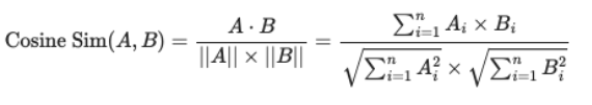

In [ ]:
# Import library for cosine
from numpy import dot
from numpy.linalg import norm

# Generated recommendation based on songs in a specific playlist.
def generate_recommendation(all_dataset, vector, not_in_playlist):
    """
    Input: 
    df (pandas dataframe): spotify dataframe
    features (pandas series): summarized playlist feature (single vector)
    not_in_playlist (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Output: 
    not_playlist_all_dataset_top_40: Top 40 recommendations for that playlist
    """

    # Filter original_dataset, delete tracks that are in not_in_playlist
    list_id = [row[0] for row in not_in_playlist.select('track_id').collect()]
    not_playlist_all_dataset = all_dataset.filter(all_dataset.track_id.isin(list_id))

    # Find cosine similarity between the playlist and the complete song set
    row_list = not_in_playlist.collect()
    result = []
    for row in row_list:
      array = row.__getitem__('std_features').values
      id = row.__getitem__('track_id')
      sim = float(dot(array, vector)/(norm(array)*norm(vector)))
      result.append( {"track_id": id, "sim" : sim} )
      
    # Create data frame
    similarity_dataset = spark.createDataFrame(result)

    # Join the datasets	
    not_playlist_all_dataset = not_playlist_all_dataset.join(similarity_dataset, not_playlist_all_dataset.track_id == similarity_dataset.track_id)

    not_playlist_all_dataset = not_playlist_all_dataset.dropDuplicates(["track_id"])

    # Sort and select first 10 rows
    not_playlist_all_dataset_top_10 = not_playlist_all_dataset.sort(not_playlist_all_dataset.sim.desc()).limit(10)
    
    return not_playlist_all_dataset_top_10

In [ ]:
# Genreate top 10 recommendation
recommend = generate_recommendation(all_tracks_original, playlist_vector, tracks_nonplaylist)

## Result

In [ ]:
recommend.select("track_name", "album_name", "artist_name", "sim").show(10, truncate=False)

+-----------------------------------------------------------------------+------------------------+------------+------------------+
|track_name                                                             |album_name              |artist_name |sim               |
+-----------------------------------------------------------------------+------------------------+------------+------------------+
|Dead on Arrival                                                        |Take This to Your Grave |Fall Out Boy|0.7644637197475406|
|Don't You Know Who I Think I Am?                                       |Infinity On High        |Fall Out Boy|0.7459566082877025|
|"""Who Will I Be - From """"Camp Rock""""/Soundtrack Version"""        |Camp Rock               |Demi Lovato |0.7406411003863316|
|Monkey Wrench                                                          |Greatest Hits           |Foo Fighters|0.7361496841025305|
|Champagne For My Real Friends, Real Pain For My Sham Friends           |From Under